# HSSM Tutorial Winterbrain 2025
### Nadja R. Ging-Jehli
#### Brown University
#### Lncc Lab (Michael J. Frank)

## List of Content
1. Sequential sampling models vs diffusion decision model
2. Regression-based modeling with practical neuroscience examples (within- vs. between-subject variables)
3. Posterior Predictive Checks
4. Additional Case Studies & Notes (self-tutorial)

## Pre-Setup

In [1]:
# Import modules
import numpy as np
import matplotlib as plt
import pandas as pd

import hddm_wfpt
# import os
import matplotlib as plt
plt.use('Agg')
import arviz as az
import bambi as bmb

import jax

# from patsy import dmatrix
import pathlib
import pytensor

import hssm
import ssms
from ssms.basic_simulators import simulator


## for some reason, this code below does not work anymore
#from jax.config import config
#config.update("jax_enable_x64", False)

pytensor.config.floatX = "float32"
jax.config.update("jax_enable_x64", False)


%matplotlib inline
%config InlineBackend.figure_format='retina'

hssm.set_floatX("float32")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## 1. Overview of Sequential Sampling Models

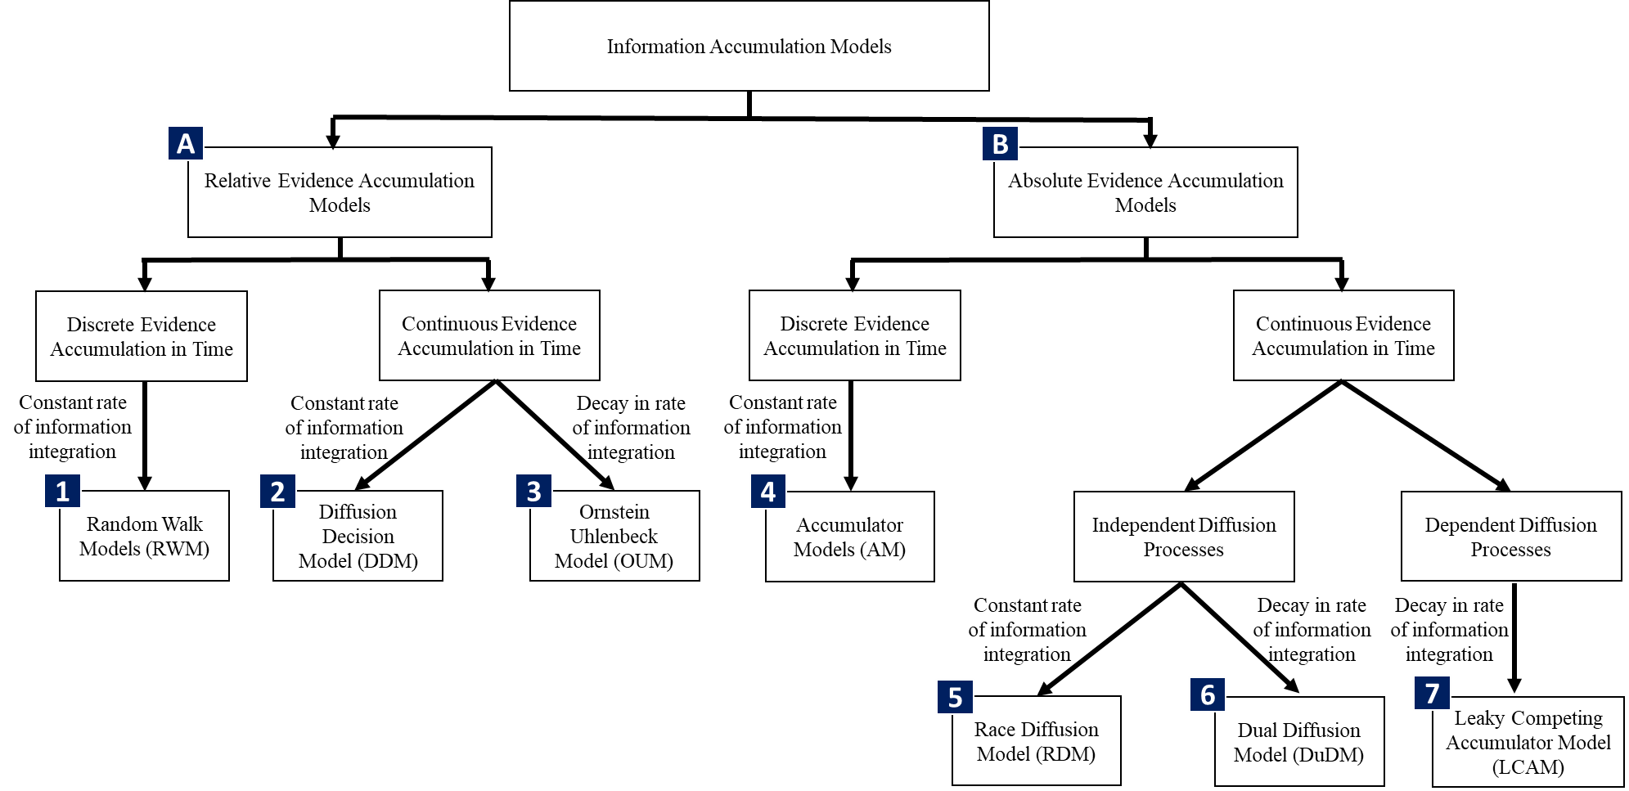

In [50]:
#![SSM_Overview](SSM_Overview.png)

from IPython.display import Image
# Display the image
Image(filename='SSM_Overview.png')


### Some Useful Papers relevant for Neuroscience (a small selection)
- Ratcliff, R., & Frank, M. J. (2012). Reinforcement-based decision making in corticostriatal circuits: mutual constraints by neurocomputational and diffusion models. Neural computation, 24(5), 1186-1229.
- Turner, B. M., Palestro, J. J., Miletić, S., & Forstmann, B. U. (2019). Advances in techniques for imposing reciprocity in brain-behavior relations. Neuroscience & Biobehavioral Reviews, 102, 327-336.
- Forstmann, B. U., Ratcliff, R., & Wagenmakers, E. J. (2016). Sequential sampling models in cognitive neuroscience: Advantages, applications, and extensions. Annual review of psychology, 67(1), 641-666.

##### blogs
https://www.gingjehli.com/research-blog

In [2]:
### Check supported models
hssm.defaults.SupportedModels

typing.Literal['ddm', 'ddm_sdv', 'full_ddm', 'angle', 'levy', 'ornstein', 'weibull', 'race_no_bias_angle_4', 'ddm_seq2_no_bias', 'lba3', 'lba2']

In [3]:
### Details about a particular model
hssm.defaults.default_model_config["weibull"]
##### the bounds within "likelihoods" provide reasonable parameter values (take this with a grain of salt)

{'response': ['rt', 'response'],
 'list_params': ['v', 'a', 'z', 't', 'alpha', 'beta'],
 'choices': [-1, 1],
 'description': None,
 'likelihoods': {'approx_differentiable': {'loglik': 'weibull.onnx',
   'backend': 'jax',
   'default_priors': {},
   'bounds': {'v': (-2.5, 2.5),
    'a': (0.3, 2.5),
    'z': (0.2, 0.8),
    't': (0.001, 2.0),
    'alpha': (0.31, 4.99),
    'beta': (0.31, 6.99)},
   'extra_fields': None}}}

In [4]:
hssm.defaults.default_model_config["full_ddm"]

{'response': ['rt', 'response'],
 'list_params': ['v', 'a', 'z', 't', 'sz', 'sv', 'st'],
 'choices': [-1, 1],
 'description': 'The full Drift Diffusion Model (DDM)',
 'likelihoods': {'blackbox': {'loglik': <function hssm.likelihoods.blackbox.hddm_to_hssm.<locals>.outer(data: numpy.ndarray, *args, **kwargs)>,
   'backend': None,
   'bounds': {'v': (-inf, inf),
    'a': (0.0, inf),
    'z': (0.0, 1.0),
    't': (0.0, inf),
    'sv': (0.0, inf),
    'sz': (0, inf),
    'st': (0, inf)},
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'extra_fields': None}}}

In [5]:
hssm.defaults.default_model_config["ddm"]

{'response': ['rt', 'response'],
 'list_params': ['v', 'a', 'z', 't'],
 'choices': [-1, 1],
 'description': 'The Drift Diffusion Model (DDM)',
 'likelihoods': {'analytical': {'loglik': <function hssm.likelihoods.analytical.logp_ddm(data: numpy.ndarray, v: float, a: float, z: float, t: float, err: float = 1e-15, k_terms: int = 20, epsilon: float = 1e-15) -> numpy.ndarray>,
   'backend': None,
   'bounds': {'v': (-inf, inf),
    'a': (0.0, inf),
    'z': (0.0, 1.0),
    't': (0.0, inf)},
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'extra_fields': None},
  'approx_differentiable': {'loglik': 'ddm.onnx',
   'backend': 'jax',
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'bounds': {'v': (-3.0, 3.0),
    'a': (0.3, 2.5),
    'z': (0.0, 1.0),
    't': (0.0, 2.0)},
   'extra_fields': None},
  'blackbox': {'loglik': <function hssm.likelihoods.blackbox.hddm_to_hssm.<locals>.outer(data: numpy.ndarray, *args, **kwargs)>,
   'backend': None,
   'bound

#### Notes
- there is a difference between "ddm" and "full_ddm"
- the bounds within "likelihoods" provide reasonable param values (but take this with a grain of salt)
- the order of "list_params" is important

## 2. Regression-based modeling 

### Case Study 1: 1 hierarchical layer (trial-level) with 1 within-subject coefficient)
- you have intracranial recording in STN and want to understand the decision-relevant dynamics in the activity
- we assume that activity in STN varies on a trial-by-trial basis in a systematic way
- your Hypothesis: STN is implicated in response cautiousness
- you want to test this hypothesis using a classical DDM
#### Question to audience: which model parameter does STN modulate?

#### Step 1: Regression-based data simulation (one subjects)

In [34]:
import numpy as np
import pandas as pd
from ssms.basic_simulators.simulator import simulator

v_true = 0.5
a_true = 1.5
z_true = 0.5
t_true = 0.5
# a changes trial wise
   #a_trialwise = np.random.normal(loc=2, scale=0.3, size=1000)
Intercept = 1.5
zSTN = np.random.normal(loc=1, scale=2, size=1000)
a_trialwise = Intercept + 0.8 * zSTN

# a changes trial wise
theta_mat = np.zeros((1000, 4))
theta_mat[:, 0] = v_true  # v
theta_mat[:, 1] = a_trialwise  # a
theta_mat[:, 2] = z_true  # z
theta_mat[:, 3] = t_true  # t

# simulate data
sim_out_trialwise = simulator(
    theta=theta_mat,  # parameter_matrix
    model="ddm",  # specify model (many are included in ssms)
    n_samples=1,  # number of samples for each set of parameters
    # (plays the role of `size` parameter in `hssm.simulate_data`)
)

# Turn into nice dataset
df_ddm_reg_case1 = pd.DataFrame(
    np.column_stack(
        [sim_out_trialwise["rts"][:, 0], sim_out_trialwise["choices"][:, 0]]
    ),
    columns=["rt", "response"],
)
df_ddm_reg_case1

rt  response
0     2.907860       1.0
1    15.181684       1.0
2     0.631313      -1.0
3     6.203048       1.0
4     6.915958       1.0
..         ...       ...
995  20.500637       1.0
996   6.156844       1.0
997   1.326174      -1.0
998  14.930737       1.0
999   0.541463      -1.0

[1000 rows x 2 columns]

#### Looking at the data, what do you notice?

#### Required Data Structure for HSSM
- we need variables labeled as "rt" and "response"
- make sure rt are in seconds (do not round!)
- responses are (1,-1) because you are in a classical DDM setting
- make sure regressors are z-scored (particularly important when you have more than two regressors)

#### Step 2: Model Setup & Priors

In [24]:
model_ddm_reg_case1 = hssm.HSSM(
    data=df_ddm_reg_case1,
    model = "ddm",
    include=[
        {
            "name": "a",
            "formula": "a ~ 1 + zSTN",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 2.5},
            }, # "initval": 0
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
)
model_ddm_reg_case1

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 919

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + zSTN
    Priors:
        a_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        a_zSTN ~ Normal(mu: 0.0, sigma: 2.5)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

##### Notes to Step 2
- make sure your priors are reasonable (always double-check)
- see my blog for useful notes for defining priors on each of these params 
https://www.gingjehli.com/single-post/choosing-effective-samplers-and-setting-priors
- priors are particularly important in these more complex regression-based models
-  it can also be helpful to set "init_val" for the sampler so it starts in a reasonable region. 

#### Step 3: Double-check model specification

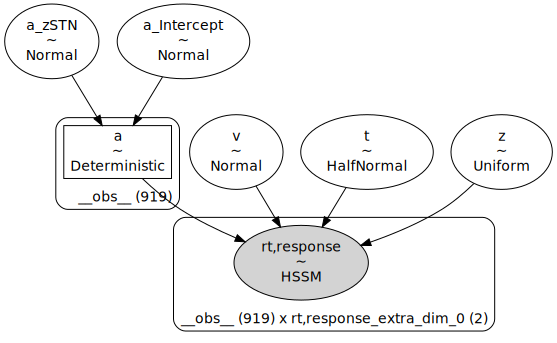

In [27]:
# graphical illustration of model
model_ddm_reg_case1.graph()

#### Step 4: Sampling from the Posterior Distribution (Bayesian Model Fitting based on MCMC Procedure)

In [36]:
samples_model_ddm_reg_case1 = model_ddm_reg_case1.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=3,  # how many chains to run
    draws=100,  # number of draws from the markov chain
    tune=50,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
    
)  # mp_ctx="forkserver")

Using default initvals. 



/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-pack

##### Notes to Step 4
- you will want at least three chains (see Andrew Gelman's suggestions)
- if models don't converge, it's typically a good idea to increase the chain length (but if model params are trading-off or your model is too complex)
- increasing burn-in really just helps to troubleshoot autocorrelation (won't help with convergence)
- depending on task structure, some model params are more/less likely to trade-off (e.g., simple task design, ter & a are often anti-correlated)
- if there are param trade-offs or depending on your regression equation, it can be helpful to play around with the sampler
- though: nuts_numpyro sampler does not work with blackbox likelihoods.
- there is also an alternative to MCMC (particularly when models become complex), it's called "Variational Inference" (VI)

#### Step 5: Model Validation

##### What do you think about these results below (also given Jensen's part)?

In [38]:
#### quick check on posterior statistics 
model_ddm_reg_case1.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_zSTN       0.783  0.026   0.747    0.806      0.014    0.011       4.0   
t            0.495  0.006   0.483    0.501      0.003    0.003       4.0   
v            0.602  0.004   0.598    0.608      0.002    0.002       5.0   
z            0.455  0.016   0.431    0.468      0.009    0.007       4.0   
a_Intercept  1.528  0.009   1.514    1.540      0.005    0.003       4.0   

             ess_tail  r_hat  
a_zSTN           11.0   2.82  
t                13.0   2.49  
v                22.0   1.93  
z                13.0   2.75  
a_Intercept      13.0   2.17

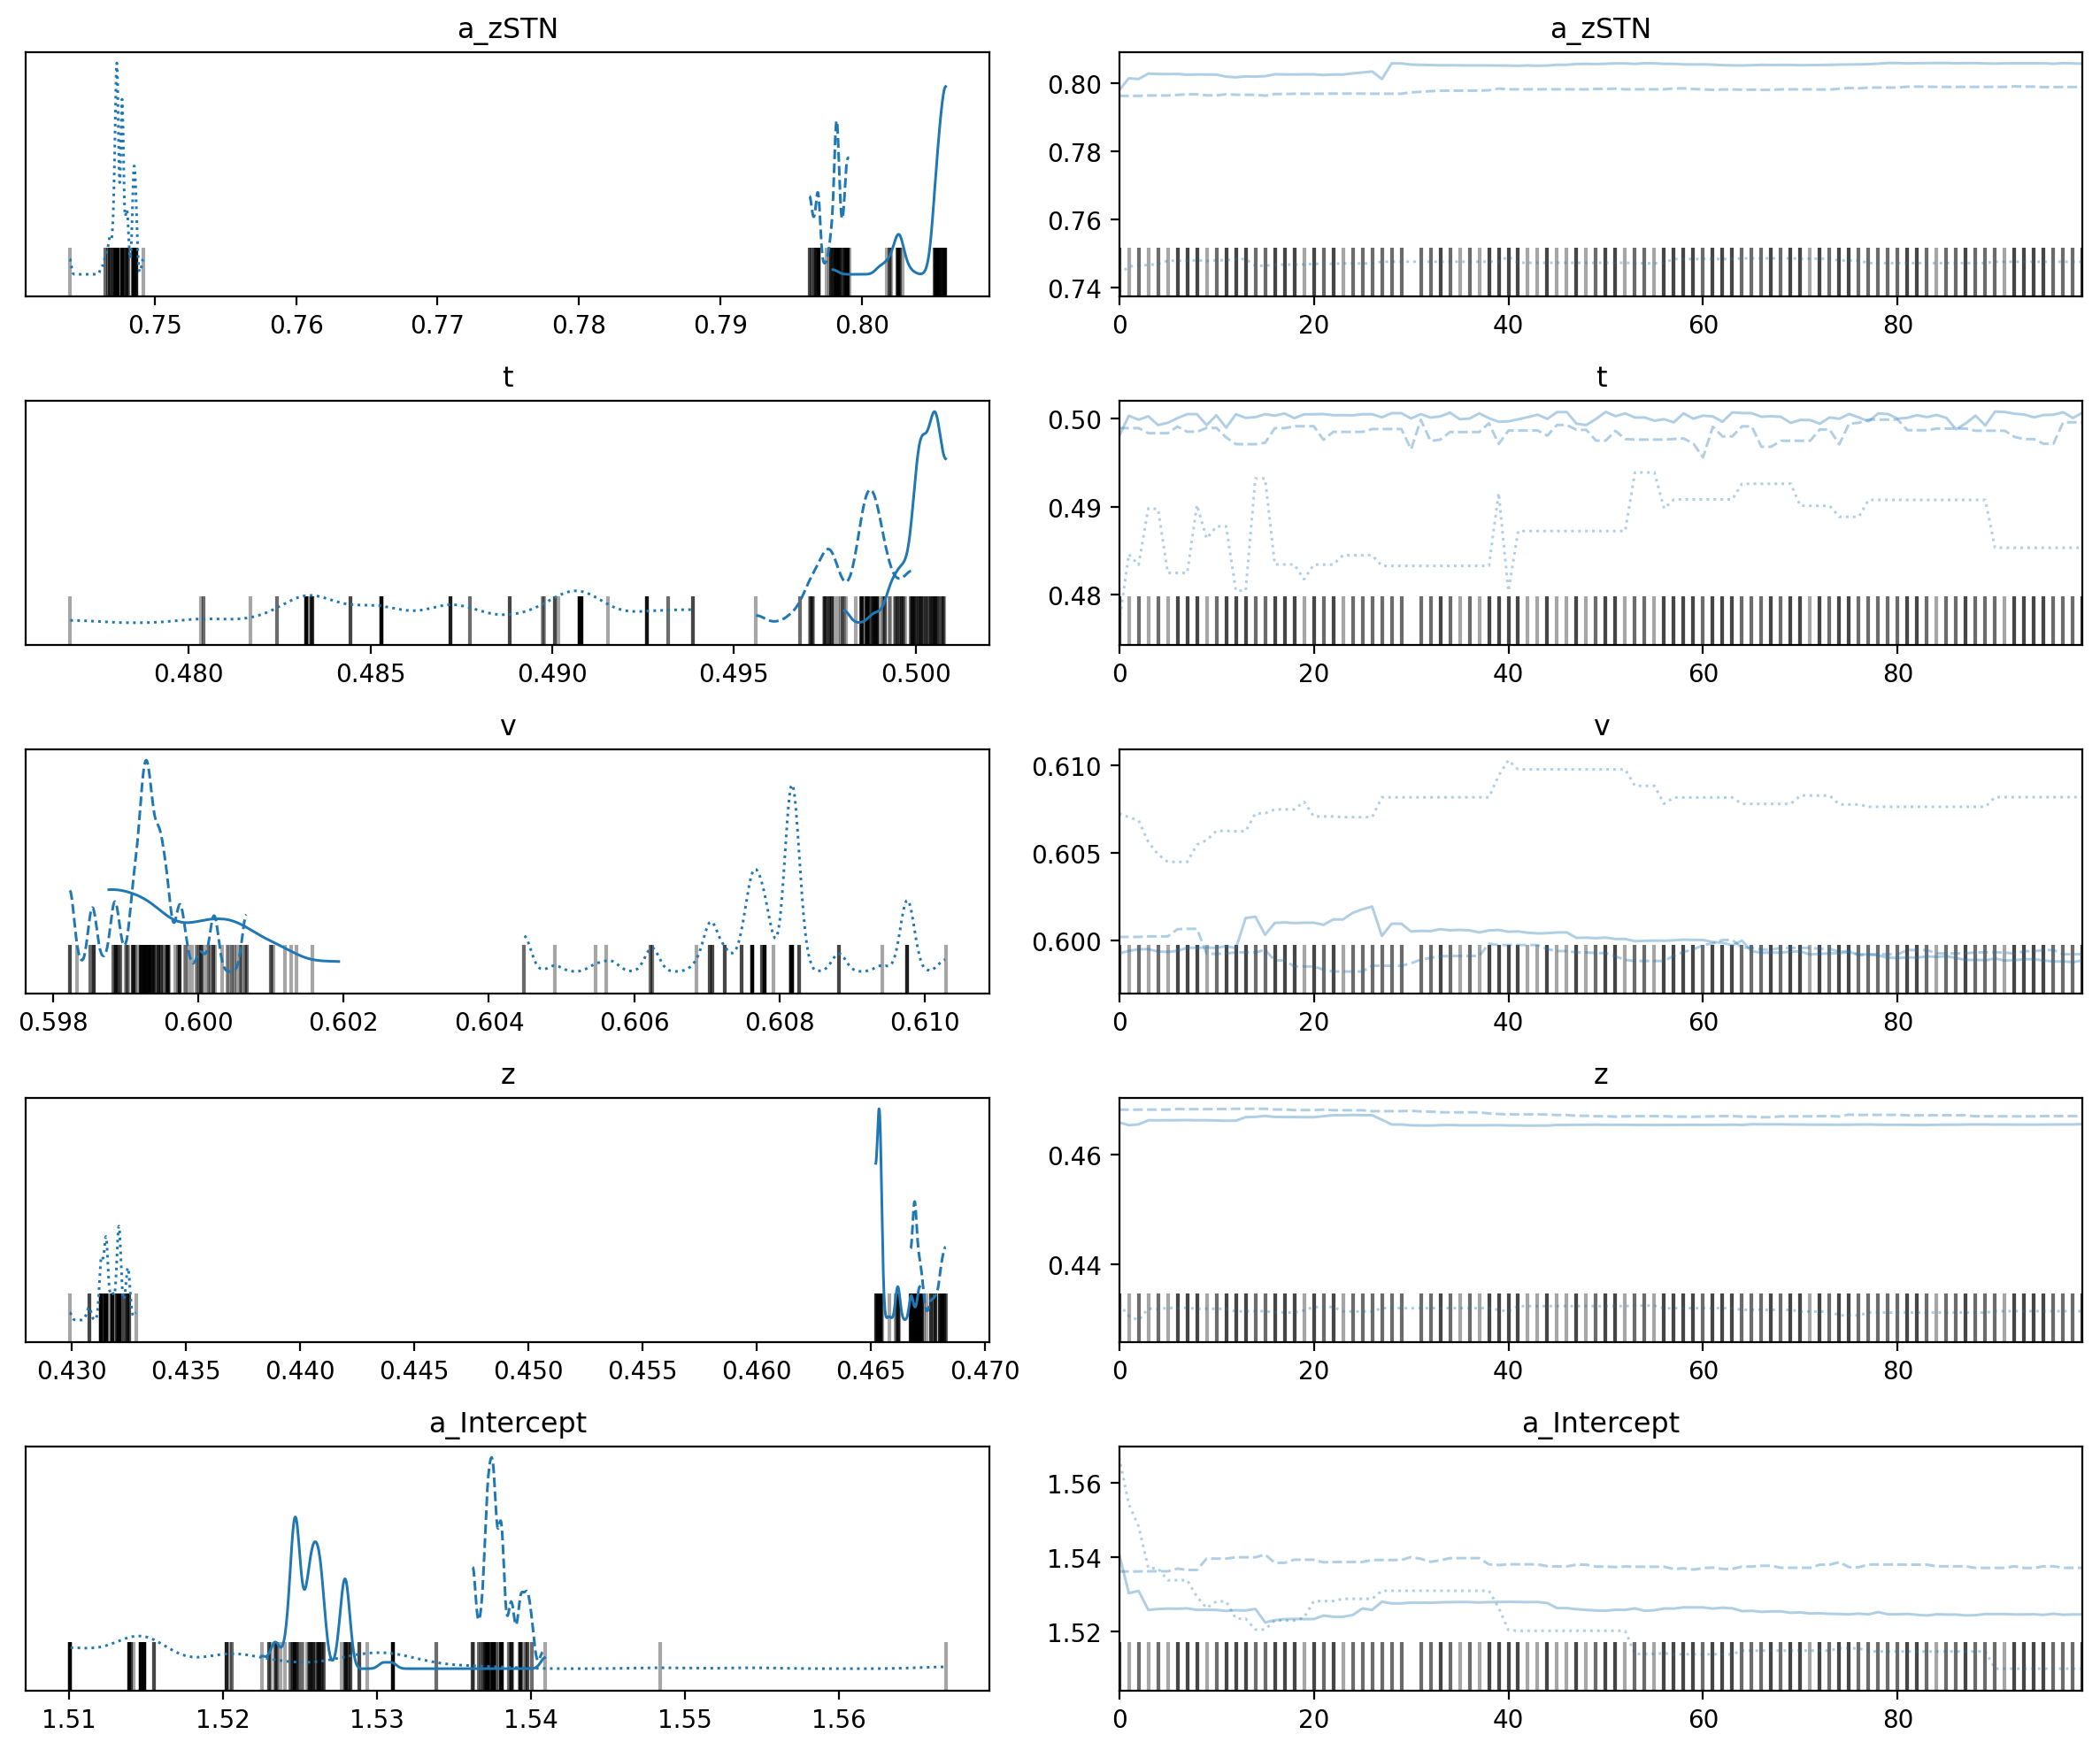

In [39]:
#### trace plots
model_ddm_reg_case1.plot_trace(); 

#### What would you do next (reminder: we draw 100 samples)?

### Case Study 2: Two hierarchical layers (trial- and subject-level) with Two within-subject coefficients

- besides from STN, we also have an indirect nogo pathway via GPe
- this time, we want to assume that activity in these components modulates drift rate
- even though there is evidence that STN modulates boundary, we always want to check different model specifications

#### Step 1: Regression-based data simulation (multiple subjects)

In [7]:
# Function to simulate data for one participant
def simulate_participant(participant_id):
    intercept = 1.5
    zSTN = np.random.normal(loc=1, scale=2, size=1000)
    zGPe = np.random.normal(loc=1, scale=2, size=1000)
    v = intercept + 0.8 * zSTN + 0.3 * zGPe
    
    # Assume `hssm.simulate_data` returns a DataFrame
    true_values = np.column_stack([v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=1000)])
    dataset_reg_v = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=1,  # Generate one data point for each of the 1000 set of true values
    )
    
    # Adding additional variables to the dataset
    dataset_reg_v["zSTN"] = zSTN
    dataset_reg_v["zGPe"] = zGPe
    dataset_reg_v["participant_id"] = participant_id
    
    return dataset_reg_v

# Simulate data for four participants
### note that we assume that STN & GPe
dataset_participant1 = simulate_participant(1)
dataset_participant2 = simulate_participant(2)
dataset_participant3 = simulate_participant(3)
dataset_participant4 = simulate_participant(4)

# Combine datasets into one DataFrame
combined_dataset = pd.concat([dataset_participant1, 
                              dataset_participant2,
                              dataset_participant3,
                              dataset_participant4
                             ], 
                             ignore_index=True)
combined_dataset

rt  response      zSTN      zGPe  participant_id
0     0.862814       1.0 -1.184913  4.175310               1
1     0.888177       1.0  2.296223  1.790889               1
2     0.840906       1.0  3.514920  1.626495               1
3     2.869982       1.0 -1.038386  1.586305               1
4     0.874767       1.0  1.777372 -2.316460               1
...        ...       ...       ...       ...             ...
3995  1.289403       1.0  1.158091 -0.716711               4
3996  0.716865       1.0  2.222428  0.833792               4
3997  0.767985       1.0  1.221256  4.609621               4
3998  0.821911       1.0  0.578094  3.089910               4
3999  0.997133       1.0  1.513471  1.945531               4

[4000 rows x 5 columns]

#### Step 2: Model Setup & Priors

##### Alternative 1: A centered model
- specification where the subject-specific coefficients are coming from one hierarchical prior (mother distribution with mu and sigma)
- we can also call it as "0+" models
- this is the specification used in HDDM
- in this case, it's important to set "noncentered=False" (by default it's set to "True")
- The group distributions here will be recovered as v_1|subject_mu and v_x|subject_mu

In [8]:
model_reg_v_ex2_A1 = hssm.HSSM(
    data=combined_dataset,
    model = "ddm",
    include=[
        {
            "name": "v",
            "formula": "v ~ 0 + (1 + zSTN + zGPe | participant_id)",
            "prior": {
              "1|participant_id": {"name": "Normal",
                                     "mu": {"name": "Normal", "mu": 1, "sigma": 2.5, "initval": 1},
                                     "sigma": {"name": "HalfNormal", "sigma": 1, "initval": .25},
                                    },
                "zSTN|participant_id": {"name": "Normal",
                                     "mu": {"name": "Normal", "mu": 1, "sigma": 2.5, "initval": 1},
                                     "sigma": {"name": "HalfNormal", "sigma": 1, "initval": .25},
                                    },
                "zGPe|participant_id": {"name": "Normal",
                                     "mu": {"name": "Normal", "mu": 1, "sigma": 2.5, "initval": 1},
                                     "sigma": {"name": "HalfNormal", "sigma": 1, "initval": .25},
                                    },
            },
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
    noncentered=False,
    p_outlier=0.05
)
model_reg_v_ex2_A1

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 4000

Parameters:

v:
    Formula: v ~ 0 + (1 + zSTN + zGPe | participant_id)
    Priors:
        v_1|participant_id ~ Normal(mu: Normal(mu: 1.0, sigma: 2.5, initval: 1.0), sigma: HalfNormal(sigma: 1.0, initval: 0.25))
        v_zSTN|participant_id ~ Normal(mu: Normal(mu: 1.0, sigma: 2.5, initval: 1.0), sigma: HalfNormal(sigma: 1.0, initval: 0.25))
        v_zGPe|participant_id ~ Normal(mu: Normal(mu: 1.0, sigma: 2.5, initval: 1.0), sigma: HalfNormal(sigma: 1.0, initval: 0.25))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

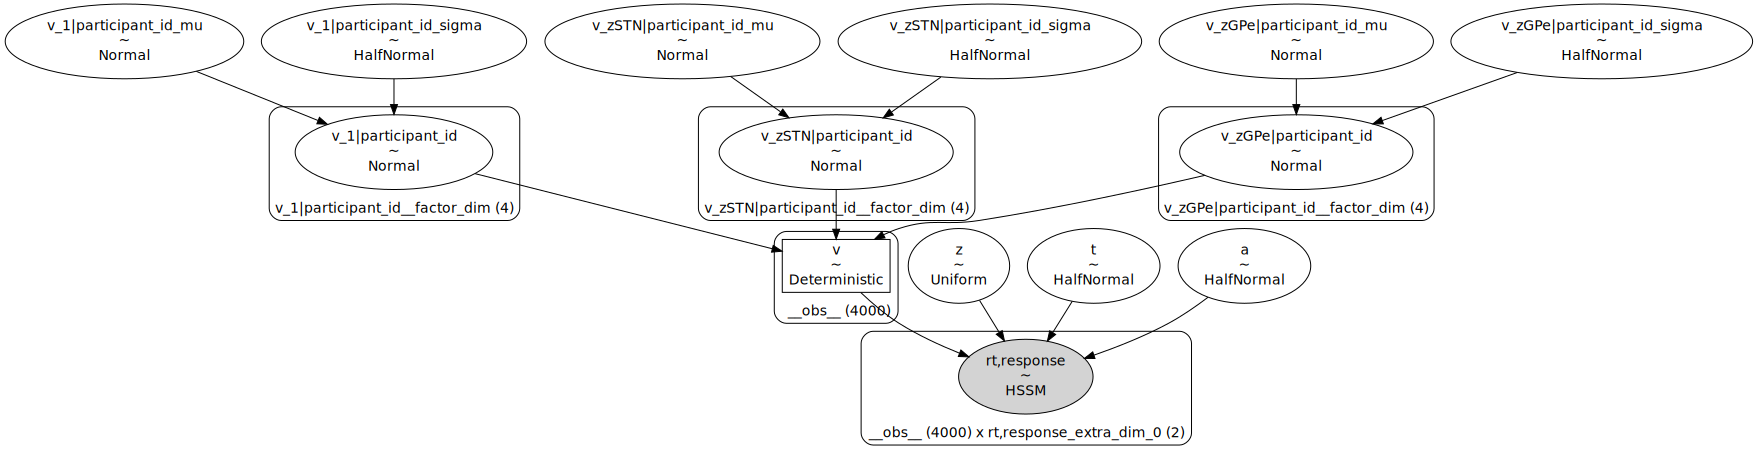

In [9]:
# graphical illustration of model
model_reg_v_ex2_A1.graph()

##### Alternative 2: A non-centered model
- Noncentered means that each subject is estimated as offset from the group mean
- in this case the group means will be zSTN and zGPe.
- The priors are different here because now we want the mu for the random subject effects to be 0
- the mu should not be estimated from a hyperprior simultaneously with the fixed effects, as those will tradeoff and could produce convergence issues  - we still estimate the sigmas with a hyperprior to allow us to get indiv params
- now we keep noncentered=true.

In [10]:
model_reg_v_ex2_A2 = hssm.HSSM(
    data=combined_dataset,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + zSTN + zGPe + (1 + zSTN + zGPe | participant_id)",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "1|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1},},
                "zSTN|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
                "zGPe|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
            },
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
    noncentered=True,
    p_outlier=0.05
)
model_reg_v_ex2_A2

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 4000

Parameters:

v:
    Formula: v ~ 1 + zSTN + zGPe + (1 + zSTN + zGPe | participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe ~ Normal(mu: 0.0, sigma: 2.5)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zSTN|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zGPe|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

### Important note
note that in this non-centered model, you will need to specify each individual coefficient's prior (at least for your regression equation). See example below

#### Step 4: Sampling from the Posterior Distribution (Bayesian Model Fitting based on MCMC Procedure)

In [15]:
## centered model version
samples_model_reg_v_ex2_A1 = model_reg_v_ex2_A1.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=3,  # how many cores to use
    chains=3,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

Using default initvals. 



/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-pack

#### Final notes:
- whether centered is better or noncentered is better depends on funnel of hell
- the two models are mathematically equivalent

#### Step 5: Model Validation

In [17]:
#### posterior statistics of centered model
model_reg_v_ex2_A1.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_1|participant_id_mu        1.563  0.049   1.478    1.654      0.003   
z                            0.489  0.010   0.471    0.508      0.000   
v_zGPe|participant_id_mu     0.304  0.018   0.272    0.340      0.001   
v_zSTN|participant_id_mu     0.802  0.098   0.712    0.854      0.019   
v_zGPe|participant_id[1]     0.296  0.016   0.266    0.323      0.001   
v_zGPe|participant_id[2]     0.298  0.014   0.269    0.322      0.000   
v_zGPe|participant_id[3]     0.311  0.015   0.283    0.342      0.001   
v_zGPe|participant_id[4]     0.309  0.016   0.282    0.340      0.001   
v_1|participant_id_sigma     0.050  0.056   0.004    0.139      0.003   
v_1|participant_id[1]        1.563  0.040   1.486    1.638      0.002   
v_1|participant_id[2]        1.568  0.039   1.495    1.640      0.002   
v_1|participant_id[3]        1.577  0.041   1.505    1.658      0.002   
v_1|participant_id[4]        1.548  0.042   1.461    1.620      0.002   
v_zSTN|participant_id_sigma  0.063  0.129   0.003    0.135      0.022   
v_zGPe|participant_id_sigma  0.024  0.026   0.001    0.063      0.001   
v_zSTN|participant_id[1]     0.791  0.020   0.753    0.826      0.001   
v_zSTN|participant_id[2]     0.760  0.023   0.720    0.803      0.001   
v_zSTN|participant_id[3]     0.807  0.020   0.771    0.845      0.001   
v_zSTN|participant_id[4]     0.794  0.019   0.761    0.830      0.001   
t                            0.499  0.005   0.490    0.508      0.000   
a                            1.499  0.024   1.455    1.542      0.001   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
v_1|participant_id_mu          0.002     297.0     494.0   1.01  
z                              0.000     432.0     557.0   1.00  
v_zGPe|participant_id_mu       0.001     670.0     557.0   1.00  
v_zSTN|participant_id_mu       0.014     192.0      50.0   1.02  
v_zGPe|participant_id[1]       0.000     801.0     703.0   1.00  
v_zGPe|participant_id[2]       0.000     875.0     833.0   1.00  
v_zGPe|participant_id[3]       0.000     827.0     793.0   1.00  
v_zGPe|participant_id[4]       0.000     668.0     833.0   1.00  
v_1|participant_id_sigma       0.002     242.0     427.0   1.00  
v_1|participant_id[1]          0.002     328.0     692.0   1.01  
v_1|participant_id[2]          0.001     365.0     727.0   1.01  
v_1|participant_id[3]          0.002     284.0     456.0   1.01  
v_1|participant_id[4]          0.002     364.0     542.0   1.00  
v_zSTN|participant_id_sigma    0.016     176.0      53.0   1.01  
v_zGPe|participant_id_sigma    0.001     257.0     344.0   1.00  
v_zSTN|participant_id[1]       0.001     751.0     814.0   1.00  
v_zSTN|participant_id[2]       0.001     812.0     891.0   1.01  
v_zSTN|participant_id[3]       0.001     815.0     951.0   1.00  
v_zSTN|participant_id[4]       0.000    1097.0     956.0   1.00  
t                              0.000     525.0     857.0   1.00  
a                              0.001    1023.0     996.0   1.01

In [18]:
#### posterior statistics of non-centered model
model_reg_v_ex2_A2.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_1|participant_id_offset[1]    -0.010  0.793  -1.522    1.499      0.022   
v_1|participant_id_offset[2]     0.096  0.815  -1.434    1.678      0.023   
v_1|participant_id_offset[3]     0.243  0.853  -1.216    1.904      0.027   
v_1|participant_id_offset[4]    -0.321  0.832  -1.961    1.163      0.028   
z                                0.488  0.010   0.471    0.506      0.000   
v_zGPe|participant_id_offset[1] -0.252  0.784  -1.767    1.160      0.023   
v_zGPe|participant_id_offset[2] -0.163  0.789  -1.580    1.326      0.026   
v_zGPe|participant_id_offset[3]  0.335  0.801  -1.069    1.969      0.028   
v_zGPe|participant_id_offset[4]  0.257  0.810  -1.238    1.782      0.027   
v_1|participant_id_sigma         0.046  0.051   0.000    0.136      0.002   
v_zGPe                           0.302  0.022   0.254    0.340      0.002   
v_zSTN|participant_id_sigma      0.044  0.039   0.000    0.116      0.002   
v_zGPe|participant_id_sigma      0.028  0.031   0.000    0.078      0.002   
v_Intercept                      1.564  0.046   1.473    1.646      0.002   
v_zSTN|participant_id_offset[1]  0.054  0.716  -1.286    1.451      0.024   
v_zSTN|participant_id_offset[2] -0.729  0.718  -2.103    0.532      0.023   
v_zSTN|participant_id_offset[3]  0.479  0.727  -0.804    1.939      0.026   
v_zSTN|participant_id_offset[4]  0.105  0.667  -1.115    1.361      0.022   
t                                0.499  0.005   0.488    0.509      0.000   
v_zSTN                           0.789  0.027   0.735    0.840      0.001   
a                                1.498  0.025   1.449    1.543      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
v_1|participant_id_offset[1]       0.021    1283.0    1027.0   1.00  
v_1|participant_id_offset[2]       0.022    1282.0     967.0   1.00  
v_1|participant_id_offset[3]       0.021    1003.0     810.0   1.00  
v_1|participant_id_offset[4]       0.021     908.0     808.0   1.00  
z                                  0.000    1266.0    1032.0   1.00  
v_zGPe|participant_id_offset[1]    0.019    1118.0    1047.0   1.01  
v_zGPe|participant_id_offset[2]    0.018     922.0     970.0   1.00  
v_zGPe|participant_id_offset[3]    0.021     824.0     957.0   1.00  
v_zGPe|participant_id_offset[4]    0.021     888.0    1072.0   1.01  
v_1|participant_id_sigma           0.001     555.0     693.0   1.00  
v_zGPe                             0.001     349.0     193.0   1.01  
v_zSTN|participant_id_sigma        0.001     331.0     341.0   1.01  
v_zGPe|participant_id_sigma        0.001     395.0     725.0   1.01  
v_Intercept                        0.001     969.0     959.0   1.01  
v_zSTN|participant_id_offset[1]    0.020     890.0     928.0   1.01  
v_zSTN|participant_id_offset[2]    0.016     953.0     763.0   1.00  
v_zSTN|participant_id_offset[3]    0.019     811.0     781.0   1.00  
v_zSTN|participant_id_offset[4]    0.018     895.0    1091.0   1.00  
t                                  0.000    1464.0    1204.0   1.00  
v_zSTN                             0.001     556.0     395.0   1.00  
a                                  0.000    1869.0     974.0   1.00

## 3. Posterior Predictive Checks

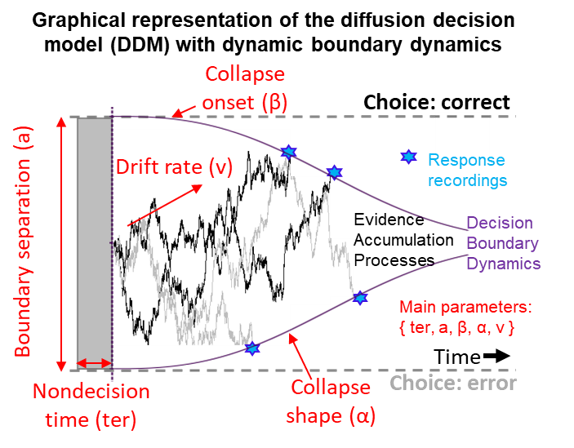

In [2]:
#![DDM_Angle](DDM_Angle.png)
from IPython.display import Image
# Display the image
Image(filename='DDM_Angle.png')

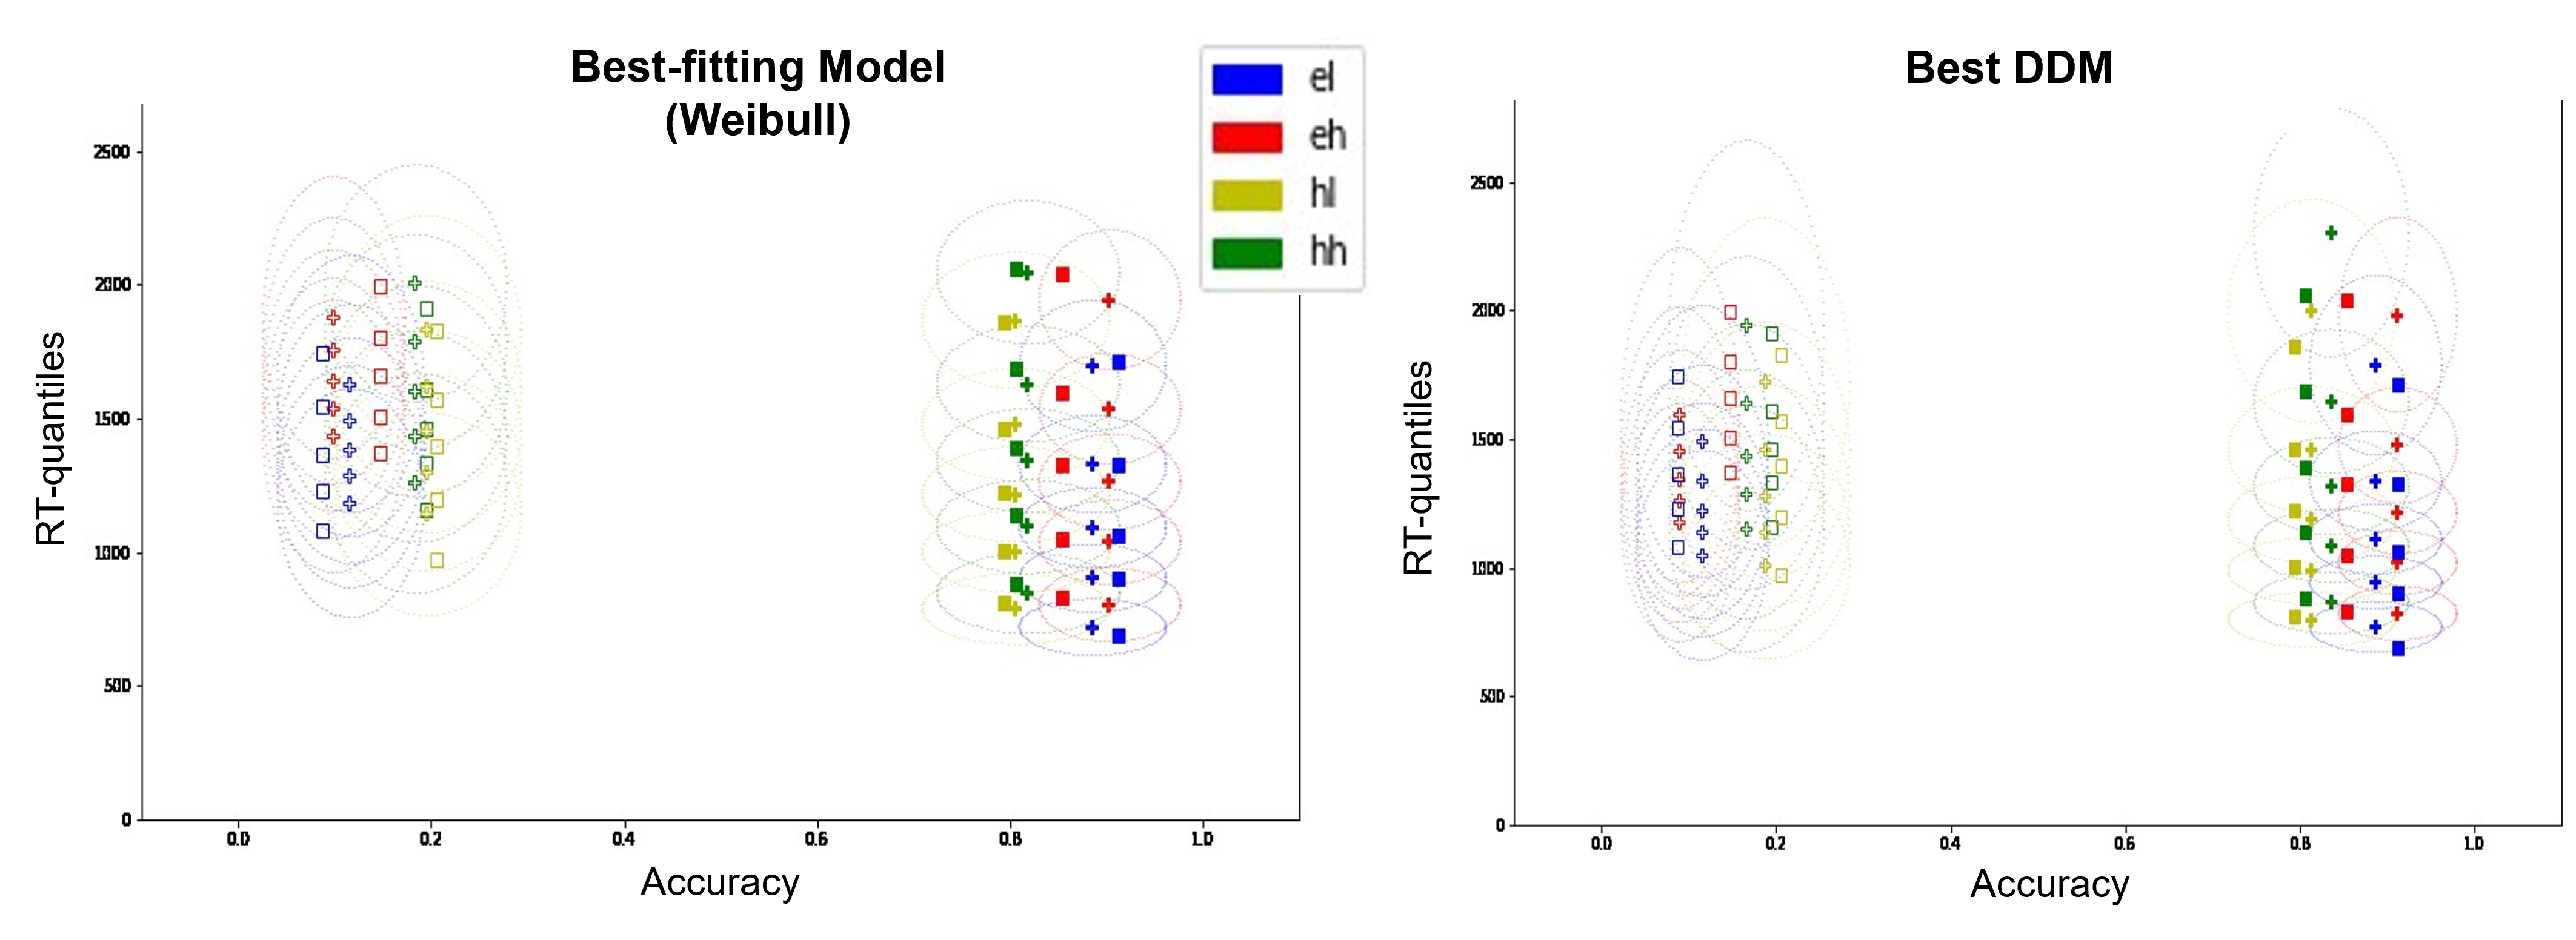

In [3]:
#![PPC_Example](PPC_Example.png)
#from IPython.display import Image
# Display the image
Image(filename='PPC_Example.png')

## code for this is available here: 
https://github.com/gingjehli/HDDM---Detailed-PPC

# Additional Case studies (between-subject & group variables)

### Case Study 3: Two hierarchical layers (trial- and sbj-level) & Two within-sbj coefficients & one btw-sbj coefficient

- we still have the intracranial recordings
- but now you have different patients and they vary in symptom severity for Parkinson
- you wonder whether those with higher symptom severity have a lower drift rate because the modulation from STN is less efficient

#### Step 1: Regression-based data simulation (multiple subjects)

In [54]:
# Function to simulate data for one participant
def simulate_participant2(participant_id,sevScore):
    intercept = 0.5
    zSTN = np.random.normal(loc=1, scale=2, size=400)
    zGPe = np.random.normal(loc=1, scale=2, size=400)

    ## Strength of neural modulation depends on PD severity score

    #### Case 1: only the interaction btw sevScore & STN/GPe will turn out sign, the main effects of STN & GPe will disappear
    # v = intercept + 0.8 * zSTN * sevScore + 0.3 * zGPe * sevScore

    #### Case 2: main effects of STN/GPe will remain, plus a significant interaction, but no modulation on intercept
    if sevScore < 0.2:
        v = intercept + 0.8 * zSTN + 0.3 * zGPe
    elif sevScore >= 0.2 and sevScore < 0.4:
        v = intercept + 0.7 * zSTN + 0.25 * zGPe
    elif sevScore >= 0.4 and sevScore < 0.6:
        v = intercept + 0.6 * zSTN + 0.2 * zGPe
    elif sevScore >= 0.6 and sevScore < 0.8:
        v = intercept + 0.5 * zSTN + 0.15 * zGPe
    else:
        v = intercept + 0.4 * zSTN + 0.1 * zGPe
    
    # Assume `hssm.simulate_data` returns a DataFrame
    true_values = np.column_stack([v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=400)])
    dataset_reg_v = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=1,  # Generate one data point for each of the 1000 set of true values
    )
    
    # Adding additional variables to the dataset
    dataset_reg_v["zSTN"] = zSTN
    dataset_reg_v["zGPe"] = zGPe
    dataset_reg_v["participant_id"] = participant_id
    dataset_reg_v["sevScore"] = sevScore
    
    return dataset_reg_v

# Simulate data for four participants
### note that we assume that STN & GPe

# patients with severity scores
dataset2_participant1 = simulate_participant2(1,0.00)
dataset2_participant2 = simulate_participant2(1,0.10)
dataset2_participant3 = simulate_participant2(2,0.20)
dataset2_participant4 = simulate_participant2(3,0.30)
dataset2_participant5 = simulate_participant2(4,0.40)
dataset2_participant6 = simulate_participant2(5,0.50)
dataset2_participant7 = simulate_participant2(6,0.60)
dataset2_participant8 = simulate_participant2(7,0.70)
dataset2_participant9 = simulate_participant2(8,0.80)
dataset2_participant10 = simulate_participant2(8,0.90)
dataset2_participant11 = simulate_participant2(8,1.00)

# Combine datasets into one DataFrame
combined_dataset2 = pd.concat([dataset2_participant1, 
                              dataset2_participant2,
                              dataset2_participant3,
                              dataset2_participant4,
                              dataset2_participant5,
                              dataset2_participant6,
                              dataset2_participant7,
                              dataset2_participant8,
                              dataset2_participant9,
                              dataset2_participant10,
                              dataset2_participant11
                             ], 
                             ignore_index=True)
combined_dataset2

rt  response      zSTN      zGPe  participant_id  sevScore
0     1.271577       1.0  1.157025  2.209306               1       0.0
1     0.759461       1.0  3.811604  2.636647               1       0.0
2     0.909292       1.0  3.702103 -1.429866               1       0.0
3     0.777792       1.0  0.860031  3.187666               1       0.0
4     1.009851       1.0  2.094822 -0.584404               1       0.0
...        ...       ...       ...       ...             ...       ...
4395  0.988492       1.0  2.296096 -0.025760               8       1.0
4396  1.365113       1.0  2.775992  0.471598               8       1.0
4397  6.872742       1.0 -0.625128  3.092331               8       1.0
4398  1.410839       1.0  2.612985  0.797299               8       1.0
4399  1.231787       1.0 -0.327202  4.213643               8       1.0

[4400 rows x 6 columns]

#### Step 2: Model Setup & Priors

In [56]:
model_reg_v_ex3_A1 = hssm.HSSM(
    data=combined_dataset2,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id)",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "1|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1},},
                "zSTN|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
                "zGPe|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
            },
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
    noncentered=True,
    p_outlier=0.05
)
model_reg_v_ex3_A1

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 4400

Parameters:

v:
    Formula: v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe ~ Normal(mu: 0.0, sigma: 2.5)
        v_sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zSTN|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zGPe|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2

In [57]:
samples_model_reg_v_ex3_A1 = model_reg_v_ex3_A1.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=3,  # how many cores to use
    chains=3,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

Using default initvals. 



/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-pack

In [58]:
#### posterior statistics of non-centered model
model_reg_v_ex3_A1.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_1|participant_id_offset[1]     0.112  0.800  -1.559    1.481      0.025   
v_1|participant_id_offset[2]     0.549  0.797  -0.945    2.014      0.023   
v_1|participant_id_offset[3]     0.708  0.789  -0.673    2.247      0.020   
v_1|participant_id_offset[4]    -0.361  0.755  -1.773    1.106      0.019   
v_1|participant_id_offset[5]    -0.561  0.756  -1.997    0.838      0.022   
v_1|participant_id_offset[6]    -0.396  0.761  -1.901    0.932      0.019   
v_1|participant_id_offset[7]    -0.384  0.787  -1.919    1.155      0.020   
v_1|participant_id_offset[8]     0.480  0.839  -1.165    1.933      0.028   
v_zSTN:sevScore                 -0.390  0.058  -0.486   -0.277      0.003   
z                                0.490  0.006   0.479    0.503      0.000   
v_zGPe|participant_id_offset[1]  0.295  0.832  -1.182    1.986      0.027   
v_zGPe|participant_id_offset[2] -0.151  0.805  -1.839    1.199      0.024   
v_zGPe|participant_id_offset[3]  0.319  0.801  -1.098    1.924      0.023   
v_zGPe|participant_id_offset[4] -0.677  0.832  -2.207    1.023      0.021   
v_zGPe|participant_id_offset[5]  0.902  0.802  -0.720    2.340      0.024   
v_zGPe|participant_id_offset[6] -0.009  0.782  -1.519    1.442      0.020   
v_zGPe|participant_id_offset[7] -0.380  0.846  -2.104    1.082      0.030   
v_zGPe|participant_id_offset[8] -0.351  0.835  -1.840    1.335      0.033   
v_sevScore                      -0.066  0.104  -0.242    0.133      0.005   
v_1|participant_id_sigma         0.057  0.038   0.002    0.124      0.002   
v_zGPe                           0.284  0.025   0.237    0.326      0.001   
v_zGPe:sevScore                 -0.160  0.045  -0.238   -0.077      0.003   
v_zSTN|participant_id_sigma      0.024  0.022   0.000    0.061      0.001   
v_zGPe|participant_id_sigma      0.025  0.018   0.000    0.055      0.001   
v_Intercept                      0.555  0.059   0.450    0.664      0.002   
v_zSTN|participant_id_offset[1]  0.565  0.894  -1.181    2.133      0.026   
v_zSTN|participant_id_offset[2] -0.228  0.832  -1.856    1.235      0.023   
v_zSTN|participant_id_offset[3]  0.126  0.846  -1.443    1.740      0.020   
v_zSTN|participant_id_offset[4] -0.330  0.893  -1.964    1.359      0.022   
v_zSTN|participant_id_offset[5]  0.283  0.843  -1.176    1.971      0.019   
v_zSTN|participant_id_offset[6] -0.300  0.840  -1.874    1.211      0.028   
v_zSTN|participant_id_offset[7]  0.259  0.861  -1.352    1.856      0.028   
v_zSTN|participant_id_offset[8] -0.394  0.890  -2.117    1.230      0.027   
t                                0.508  0.006   0.496    0.520      0.000   
v_zSTN                           0.790  0.031   0.731    0.844      0.002   
a                                1.488  0.017   1.457    1.520      0.000   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
v_1|participant_id_offset[1]       0.020    1009.0    1059.0   1.01  
v_1|participant_id_offset[2]       0.018    1194.0     843.0   1.00  
v_1|participant_id_offset[3]       0.015    1578.0     997.0   1.00  
v_1|participant_id_offset[4]       0.019    1505.0     997.0   1.00  
v_1|participant_id_offset[5]       0.017    1180.0    1007.0   1.00  
v_1|participant_id_offset[6]       0.018    1665.0    1045.0   1.00  
v_1|participant_id_offset[7]       0.020    1569.0    1032.0   1.00  
v_1|participant_id_offset[8]       0.020     932.0    1075.0   1.00  
v_zSTN:sevScore                    0.002     439.0     370.0   1.01  
z                                  0.000    1565.0    1167.0   1.00  
v_zGPe|participant_id_offset[1]    0.019     940.0     849.0   1.00  
v_zGPe|participant_id_offset[2]    0.020    1124.0    1095.0   1.00  
v_zGPe|participant_id_offset[3]    0.020    1175.0     983.0   1.00  
v_zGPe|participant_id_offset[4]    0.019    1469.0     926.0   1.00  
v_zGPe|participant_id_offset[5]    0.017    1082.0    1054.0   1.00  
v_zGPe|participant_id_offset[6]    0.018    1503.0     951.0   1

- there is no main effect of severity (makes sense because we didn't change the intercept by severity!)
- you can see that by looking at the credible interval (hdi's). They are interpret similar to confidence intervals
- the intercept itself is recovered well (input: 0.5)
- the effect of severity onto STN is significant. This is good because we did manipulate that (0.6 was around the mean effect)

### Case Study 4: Two hierarchical layers (trial- and sbj-level) & Two within-sbj coefficients & one btw-sbj coefficient & group

- we still have the intracranial recordings
- but now you have different patients and they vary in symptom severity for Parkinson
- you wonder whether those with higher symptom severity have a lower drift rate because the modulation from STN is less efficient

BUT NOW: your friend is a clinician and tells you that some people might have Dystonia rather than Parkinson and they show different symptoms.
So, you want to take this into account now

##### Audience Question: how would you do that? How would you change the data simulation?

#### Step 1: Regression-based data simulation (multiple subjects)

In [59]:
# Function to simulate data for one participant
def simulate_participant3(participant_id,sevScore,diagnosis):
    #intercept = 0.5
    zSTN = np.random.normal(loc=1, scale=2, size=400)
    zGPe = np.random.normal(loc=1, scale=2, size=400)

    if diagnosis == "PD":
        intercept = 0.3
    else:
        intercept = 0.6

    ## Strength of neural modulation depends on PD severity score
    if sevScore <= 0.2:
        v = intercept + 0.8 * zSTN + 0.3 * zGPe
    elif sevScore > 0.2 and sevScore <= 0.4:
        v = intercept + 0.6 * zSTN + 0.2 * zGPe
    elif sevScore > 0.4 and sevScore < 0.6:
        v = intercept + 0.5 * zSTN + 0.1 * zGPe
    else:
        v = intercept + 0.4 * zSTN + 0.0 * zGPe
    
    # Assume `hssm.simulate_data` returns a DataFrame
    true_values = np.column_stack([v, np.repeat([[1.5, 0.5, 0.5]], axis=0, repeats=400)])
    dataset_reg_v = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=1,  # Generate one data point for each of the 1000 set of true values
    )
    
    # Adding additional variables to the dataset
    dataset_reg_v["zSTN"] = zSTN
    dataset_reg_v["zGPe"] = zGPe
    dataset_reg_v["participant_id"] = participant_id
    dataset_reg_v["sevScore"] = sevScore
    dataset_reg_v["diagnosis"] = diagnosis
    
    return dataset_reg_v

# Simulate data for four participants
### note that we assume that STN & GPe

## PD patients:
# patients with low severity scores
dataset2_participant1 = simulate_participant3(1,0.10,"PD")
dataset2_participant2 = simulate_participant3(2,0.20,"PD")
dataset2_participant3 = simulate_participant3(3,0.30,"PD")
dataset2_participant4 = simulate_participant3(4,0.40,"PD")
# patients with high severity scores
dataset2_participant5 = simulate_participant3(5,0.50,"PD")
dataset2_participant6 = simulate_participant3(6,0.60,"PD")
dataset2_participant7 = simulate_participant3(7,0.70,"PD")
dataset2_participant8 = simulate_participant3(8,0.80,"PD")

## Dystonia patients:
# patients with low severity scores
dataset2_participant9 = simulate_participant3(1,0.10,"DD")
dataset2_participant10 = simulate_participant3(2,0.20,"DD")
dataset2_participant11 = simulate_participant3(3,0.30,"DD")
dataset2_participant12 = simulate_participant3(4,0.40,"DD")
# patients with high severity scores
dataset2_participant13 = simulate_participant3(5,0.50,"DD")
dataset2_participant14 = simulate_participant3(6,0.60,"DD")
dataset2_participant15 = simulate_participant3(7,0.70,"DD")
dataset2_participant16 = simulate_participant3(8,0.80,"DD")

# Combine datasets into one DataFrame
combined_dataset3 = pd.concat([dataset2_participant1, 
                              dataset2_participant2,
                              dataset2_participant3,
                              dataset2_participant4,
                              dataset2_participant5,
                              dataset2_participant6,
                              dataset2_participant7,
                              dataset2_participant8,
                              dataset2_participant9,
                              dataset2_participant10,
                              dataset2_participant11,
                              dataset2_participant12,
                              dataset2_participant13,
                              dataset2_participant14,
                              dataset2_participant15,
                              dataset2_participant16
                             ], 
                             ignore_index=True)
combined_dataset3

rt  response      zSTN      zGPe  participant_id  sevScore  \
0     0.873857       1.0  3.637730  0.265186               1       0.1   
1     0.908324       1.0  3.633810  3.808348               1       0.1   
2     3.980345      -1.0 -1.269445  2.671654               1       0.1   
3     1.543903       1.0  1.481238 -2.074491               1       0.1   
4     1.003744       1.0  2.084844  1.668075               1       0.1   
...        ...       ...       ...       ...             ...       ...   
6395  0.956703       1.0  2.467037  3.054123               8       0.8   
6396  1.071704       1.0 -1.388284  0.699751               8       0.8   
6397  0.875745       1.0  1.267933  0.754537               8       0.8   
6398  0.812687      -1.0 -2.910345  2.516412               8       0.8   
6399  1.022560       1.0  6.796676  0.106029               8       0.8   

     diagnosis  
0           PD  
1           PD  
2           PD  
3           PD  
4           PD  
...        ...  
6395        DD  
6396        DD  
6397        DD  
6398        DD  
6399        DD  

[6400 rows x 7 columns]

In [61]:
model_reg_v_ex4_A1 = hssm.HSSM(
    data=combined_dataset3,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id)",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "1|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1},},
                "zSTN|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
                "zGPe|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
            },
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
    noncentered=True,
    p_outlier=0.05
)
model_reg_v_ex4_A1

Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 6400

Parameters:

v:
    Formula: v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe ~ Normal(mu: 0.0, sigma: 2.5)
        v_sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zSTN:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zGPe:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zSTN:sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zGPe:sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v

In [62]:
samples_model_reg_v_ex4_A1 = model_reg_v_ex4_A1.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=3,  # how many cores to use
    chains=3,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

Using default initvals. 



/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-pack

In [63]:
#### posterior statistics of non-centered model
model_reg_v_ex4_A1.summary()

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_zSTN|participant_id_sigma       0.086  0.044   0.035    0.142      0.003   
v_sevScore:C(diagnosis)[PD]       0.109  0.102  -0.082    0.293      0.003   
v_zSTN:sevScore:C(diagnosis)[PD]  0.053  0.056  -0.054    0.152      0.002   
v_zGPe|participant_id_offset[1]  -0.061  0.723  -1.490    1.263      0.024   
v_zGPe|participant_id_offset[2]   0.864  0.673  -0.328    2.162      0.022   
v_zGPe|participant_id_offset[3]  -0.318  0.549  -1.397    0.661      0.018   
v_zGPe|participant_id_offset[4]   0.354  0.511  -0.571    1.385      0.014   
v_zGPe|participant_id_offset[5]  -0.732  0.511  -1.772    0.166      0.015   
v_zGPe|participant_id_offset[6]  -1.178  0.609  -2.323   -0.103      0.020   
v_zGPe|participant_id_offset[7]   0.086  0.606  -1.119    1.160      0.018   
v_zGPe|participant_id_offset[8]   1.075  0.754  -0.405    2.464      0.028   
v_1|participant_id_offset[1]     -0.161  0.960  -1.952    1.655      0.019   
v_1|participant_id_offset[2]      0.266  0.914  -1.525    1.871      0.022   
v_1|participant_id_offset[3]      0.070  0.917  -1.585    1.882      0.021   
v_1|participant_id_offset[4]     -0.286  0.912  -2.032    1.386      0.018   
v_1|participant_id_offset[5]      0.027  0.903  -1.756    1.708      0.021   
v_1|participant_id_offset[6]      0.061  0.881  -1.540    1.714      0.018   
v_1|participant_id_offset[7]     -0.061  0.959  -1.708    1.947      0.024   
v_1|participant_id_offset[8]     -0.020  0.931  -1.719    1.728      0.023   
v_sevScore                       -0.024  0.086  -0.179    0.138      0.003   
v_Intercept                       0.656  0.047   0.573    0.748      0.001   
v_zGPe:C(diagnosis)[PD]          -0.003  0.025  -0.048    0.042      0.001   
v_zSTN                            0.879  0.075   0.741    1.024      0.004   
z                                 0.500  0.006   0.489    0.510      0.000   
v_zGPe:sevScore:C(diagnosis)[PD]  0.015  0.047  -0.069    0.104      0.001   
v_zGPe:sevScore                  -0.537  0.090  -0.696   -0.349      0.004   
v_zSTN:C(diagnosis)[PD]          -0.047  0.031  -0.106    0.009      0.001   
a                                 1.497  0.013   1.471    1.520      0.000   
v_zSTN:sevScore                  -0.662  0.145  -0.921   -0.382      0.007   
v_1|participant_id_sigma          0.018  0.016   0.000    0.045      0.001   
v_zGPe                            0.375  0.047   0.290    0.468      0.002   
v_zSTN|participant_id_offset[1]  -0.066  0.658  -1.257    1.195      0.027   
v_zSTN|participant_id_offset[2]   1.314  0.678   0.041    2.643      0.029   
v_zSTN|participant_id_offset[3]  -0.825  0.538  -1.769    0.277      0.020   
v_zSTN|participant_id_offset[4]  -0.139  0.427  -0.943    0.656      0.015   
v_zSTN|participant_id_offset[5]   0.079  0.437  -0.721    0.918      0.017   
v_zSTN|participant_id_offset[6]  -0.998  0.542  -1.974   -0.007      0.021   
v_zSTN|participant_id_offset[7]  -0.175  0.555  -1.201    0.850      0.022   
v_zSTN|participant_id_offset[8]   0.885  0.719  -0.488    2.221      0.030   
t                                 0.513  0.005   0.503    0.523      0.000   
v_C(diagnosis)[PD]               -0.376  0.054  -0.487   -0.278      0.002   
v_zGPe|participant_id_sigma       0.050  0.020   0.018    0.084      0.001   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
v_zSTN|participant_id_sigma         0.002     455.0     512.0   1.00  
v_sevScore:C(diagnosis)[PD]         0.002     882.0    1058.0   1.00  
v_zSTN:sevScore:C(diagnosis)[PD]    0.001    1177.0    1154.0   1.01  
v_zGPe|participant_id_offset[1]     0.017     876.0     973.0   1.00  
v_zGPe|participant_id_offset[2]     0.015     936.0     911.0   1.00  
v_zGPe|participant_id_offset[3]     0.013     904.0    1055.0   1.00  
v_zGPe|participant_id_offset[4]     0.012    1254.0    1100.0   1.00  
v_zGPe|participant_id_offset[5]     0.011    1170.0    1029.0   1.00  
v_zGPe|participant_id_offset[6]     0.014

In [84]:
parameters = list(samples_model_reg_v_ex4_A1.posterior.keys())
# Print each parameter on a separate line
print("Model parameters:\n" + "\n".join(parameters))
#print("Model parameters:", parameters)

Model parameters:
z
v_zGPe|participant_id
v_zGPe:sevScore:C(diagnosis)
v_zSTN|participant_id_sigma
v_zGPe:sevScore
v_zSTN:C(diagnosis)
v_zSTN|participant_id
v_sevScore:C(diagnosis)
v_zSTN:sevScore:C(diagnosis)
v_zGPe|participant_id_offset
a
v_1|participant_id_offset
v_zSTN:sevScore
v_sevScore
v_1|participant_id_sigma
v_1|participant_id
v_zGPe
v_Intercept
v_zGPe:C(diagnosis)
v_zSTN|participant_id_offset
t
v_C(diagnosis)
v_zSTN
v_zGPe|participant_id_sigma


In [85]:
# formula used:  "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id)",
az.summary(
    samples_model_reg_v_ex4_A1, 
    var_names=["v_Intercept","v_zSTN", "v_zGPe","v_sevScore","v_C(diagnosis)",
              "v_sevScore:C(diagnosis)","v_zGPe:C(diagnosis)","v_zGPe:sevScore","v_zSTN:C(diagnosis)","v_zSTN:sevScore",
              "v_zGPe:sevScore:C(diagnosis)","v_zSTN:sevScore:C(diagnosis)"]
)  # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_Intercept                       0.656  0.047   0.573    0.748      0.001   
v_zSTN                            0.879  0.075   0.741    1.024      0.004   
v_zGPe                            0.375  0.047   0.290    0.468      0.002   
v_sevScore                       -0.024  0.086  -0.179    0.138      0.003   
v_C(diagnosis)[PD]               -0.376  0.054  -0.487   -0.278      0.002   
v_sevScore:C(diagnosis)[PD]       0.109  0.102  -0.082    0.293      0.003   
v_zGPe:C(diagnosis)[PD]          -0.003  0.025  -0.048    0.042      0.001   
v_zGPe:sevScore                  -0.537  0.090  -0.696   -0.349      0.004   
v_zSTN:C(diagnosis)[PD]          -0.047  0.031  -0.106    0.009      0.001   
v_zSTN:sevScore                  -0.662  0.145  -0.921   -0.382      0.007   
v_zGPe:sevScore:C(diagnosis)[PD]  0.015  0.047  -0.069    0.104      0.001   
v_zSTN:sevScore:C(diagnosis)[PD]  0.053  0.056  -0.054    0.152      0.002   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
v_Intercept                         0.001    1142.0    1194.0   1.00  
v_zSTN                              0.003     472.0     312.0   1.01  
v_zGPe                              0.001     617.0     703.0   1.00  
v_sevScore                          0.002    1022.0    1156.0   1.00  
v_C(diagnosis)[PD]                  0.001     896.0     945.0   1.00  
v_sevScore:C(diagnosis)[PD]         0.002     882.0    1058.0   1.00  
v_zGPe:C(diagnosis)[PD]             0.001    1106.0    1025.0   1.00  
v_zGPe:sevScore                     0.003     558.0     616.0   1.00  
v_zSTN:C(diagnosis)[PD]             0.001    1248.0    1164.0   1.01  
v_zSTN:sevScore                     0.005     500.0     560.0   1.01  
v_zGPe:sevScore:C(diagnosis)[PD]    0.001    1185.0    1000.0   1.00  
v_zSTN:sevScore:C(diagnosis)[PD]    0.001    1177.0    1154.0   1.01

#### Other Example 2

In [64]:
model_reg_v_ex4_A2 = hssm.HSSM(
    data=combined_dataset3,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id/C(diagnosis))",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "1|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1},},
                "zSTN|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
                "zGPe|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
            },
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
    noncentered=True,
    p_outlier=0.05
)
model_reg_v_ex4_A2

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 6400

Parameters:

v:
    Formula: v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id/C(diagnosis))
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe ~ Normal(mu: 0.0, sigma: 2.5)
        v_sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_1|participant_id:C(diagnosis) ~ Normal(mu: Normal(mu: 0.0, sigma: 0.25), sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
        v_zSTN|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        v_zSTN|participant_id:C(diagnosis) ~ Normal(mu: Normal(mu: 0.0, sigma: 0.25), sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
        v_zGPe|partici

In [65]:
samples_model_reg_v_ex4_A2 = model_reg_v_ex4_A2.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=3,  # how many cores to use
    chains=3,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

Using default initvals. 



/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-pack

In [66]:
#### posterior statistics of non-centered model
model_reg_v_ex4_A2.summary()

mean     sd  hdi_3%  \
v_zGPe|participant_id:C(diagnosis)_offset[1:DD]  0.374  0.893  -1.248   
v_zGPe|participant_id:C(diagnosis)_offset[1:PD] -0.406  0.924  -2.071   
v_zGPe|participant_id:C(diagnosis)_offset[2:DD] -0.085  0.880  -1.801   
v_zGPe|participant_id:C(diagnosis)_offset[2:PD]  0.466  0.916  -1.232   
v_zGPe|participant_id:C(diagnosis)_offset[3:DD] -0.347  0.892  -1.891   
...                                                ...    ...     ...   
v_zSTN|participant_id_offset[7]                 -0.171  0.605  -1.266   
v_zSTN|participant_id_offset[8]                  0.850  0.745  -0.529   
t                                                0.513  0.005   0.503   
v_zSTN|participant_id:C(diagnosis)_mu            0.004  0.250  -0.516   
v_zGPe|participant_id_sigma                      0.048  0.027   0.001   

                                                 hdi_97%  mcse_mean  mcse_sd  \
v_zGPe|participant_id:C(diagnosis)_offset[1:DD]    2.277      0.020    0.023   
v_zGPe|participant_id:C(diagnosis)_offset[1:PD]    1.342      0.020    0.023   
v_zGPe|participant_id:C(diagnosis)_offset[2:DD]    1.504      0.022    0.023   
v_zGPe|participant_id:C(diagnosis)_offset[2:PD]    2.130      0.023    0.021   
v_zGPe|participant_id:C(diagnosis)_offset[3:DD]    1.491      0.020    0.022   
...                                                  ...        ...      ...   
v_zSTN|participant_id_offset[7]                    0.960      0.020    0.014   
v_zSTN|participant_id_offset[8]                    2.302      0.024    0.017   
t                                                  0.523      0.000    0.000   
v_zSTN|participant_id:C(diagnosis)_mu              0.413      0.005    0.007   
v_zGPe|participant_id_sigma                        0.092      0.001    0.001   

                                                 ess_bulk  ess_tail  r_hat  
v_zGPe|participant_id:C(diagnosis)_offset[1:DD]    2079.0    1005.0   1.00  
v_zGPe|participant_id:C(diagnosis)_offset[1:PD]    2034.0    1198.0   1.00  
v_zGPe|participant_id:C(diagnosis)_offset[2:DD]    1616.0    1173.0   1.01  
v_zGPe|participant_id:C(diagnosis)_offset[2:PD]    1541.0    1055.0   1.00  
v_zGPe|participant_id:C(diagnosis)_offset[3:DD]    1942.0     999.0   1.00  
...                                                   ...       ...    ...  
v_zSTN|participant_id_offset[7]                     957.0    1166.0   1.00  
v_zSTN|participant_id_offset[8]                     994.0     970.0   1.00  
t                                                  2361.0    1089.0   1.00  
v_zSTN|participant_id:C(diagnosis)_mu              2088.0    1187.0   1.00  
v_zGPe|participant_id_sigma                         451.0     597.0   1.00  

[90 rows x 9 columns]

In [82]:
parameters = list(samples_model_reg_v_ex4_A2.posterior.keys())
# Print each parameter on a separate line
print("Model parameters:\n" + "\n".join(parameters))
#print("Model parameters:", parameters)

Model parameters:
v_zGPe|participant_id:C(diagnosis)_offset
z
v_zSTN|participant_id:C(diagnosis)
v_1|participant_id:C(diagnosis)_sigma
v_zGPe|participant_id
v_zSTN|participant_id_sigma
v_zGPe|participant_id:C(diagnosis)_sigma
v_zGPe:sevScore
v_1|participant_id:C(diagnosis)_mu
v_zSTN|participant_id
v_zGPe|participant_id_offset
v_1|participant_id:C(diagnosis)
v_1|participant_id_offset
a
v_zSTN|participant_id:C(diagnosis)_offset
v_zSTN:sevScore
t
v_sevScore
v_zGPe|participant_id:C(diagnosis)_mu
v_1|participant_id_sigma
v_1|participant_id
v_zGPe
v_1|participant_id:C(diagnosis)_offset
v_Intercept
v_zSTN|participant_id:C(diagnosis)_sigma
v_zSTN|participant_id_offset
v_zGPe|participant_id:C(diagnosis)
v_zSTN|participant_id:C(diagnosis)_mu
v_zSTN
v_zGPe|participant_id_sigma


In [83]:
# function: "formula": "v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id/C(diagnosis))",

az.summary(
    samples_model_reg_v_ex4_A2, 
    var_names=["v_Intercept","v_zSTN", "v_zGPe","v_sevScore",
              "v_zGPe:sevScore","v_zSTN:sevScore",
              "v_1|participant_id:C(diagnosis)_mu","v_zSTN|participant_id:C(diagnosis)_mu","v_zGPe|participant_id:C(diagnosis)_mu"]
)  # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  \
v_Intercept                            0.470  0.139   0.210    0.745   
v_zSTN                                 0.863  0.072   0.730    0.992   
v_zGPe                                 0.375  0.048   0.291    0.467   
v_sevScore                             0.040  0.276  -0.500    0.551   
v_zGPe:sevScore                       -0.529  0.093  -0.723   -0.360   
v_zSTN:sevScore                       -0.645  0.141  -0.919   -0.391   
v_1|participant_id:C(diagnosis)_mu    -0.008  0.265  -0.513    0.468   
v_zSTN|participant_id:C(diagnosis)_mu  0.004  0.250  -0.516    0.413   
v_zGPe|participant_id:C(diagnosis)_mu  0.005  0.254  -0.458    0.456   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v_Intercept                                0.006    0.004     584.0     703.0   
v_zSTN                                     0.003    0.003     616.0     485.0   
v_zGPe                                     0.002    0.002     597.0     424.0   
v_sevScore                                 0.012    0.008     577.0     683.0   
v_zGPe:sevScore                            0.004    0.003     737.0     519.0   
v_zSTN:sevScore                            0.005    0.004     750.0     649.0   
v_1|participant_id:C(diagnosis)_mu         0.005    0.008    2484.0     878.0   
v_zSTN|participant_id:C(diagnosis)_mu      0.005    0.007    2088.0    1187.0   
v_zGPe|participant_id:C(diagnosis)_mu      0.005    0.008    2758.0    1102.0   

                                       r_hat  
v_Intercept                             1.00  
v_zSTN                                  1.01  
v_zGPe                                  1.00  
v_sevScore                              1.00  
v_zGPe:sevScore                         1.00  
v_zSTN:sevScore                         1.01  
v_1|participant_id:C(diagnosis)_mu      1.01  
v_zSTN|participant_id:C(diagnosis)_mu   1.00  
v_zGPe|participant_id:C(diagnosis)_mu   1.00

#### Other Example 3

In [67]:
model_reg_v_ex4_A3 = hssm.HSSM(
    data=combined_dataset3,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id/C(diagnosis))",
            "prior": {
                # All ways to specify priors in the non-regression case work the same way here.
                "Intercept": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zSTN:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "zGPe:sevScore": {"name": "Normal", "mu": 0, "sigma": 2.5},
                "1|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1},},
                "zSTN|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
                "zGPe|participant_id": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal","sigma": 1}},
            },
            "link": "identity",
            # "bounds": (-10.0, 10.0)
        }
    ],
    noncentered=True,
    p_outlier=0.05
)
model_reg_v_ex4_A3

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 6400

Parameters:

v:
    Formula: v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id/C(diagnosis))
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe ~ Normal(mu: 0.0, sigma: 2.5)
        v_sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zSTN:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_zGPe:sevScore ~ Normal(mu: 0.0, sigma: 2.5)
        v_C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zSTN:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zGPe:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zSTN:sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_zGPe:sevScore:C(diagnosis) ~ Normal(mu: 0.0, sigma: 0.25)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.

In [68]:
samples_model_reg_v_ex4_A3 = model_reg_v_ex4_A3.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=3,  # how many cores to use
    chains=3,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

Using default initvals. 



/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/users/ngingje1/.conda/envs/pyHSSM6/lib/python3.11/site-pack

In [71]:
#### posterior statistics of non-centered model
model_reg_v_ex4_A3.summary()

#az.summary(
#    model_reg_v_ex4_A3,
#    var_names=[var_name.name for var_name in simple_ddm_model.pymc_model.free_RVs],
#)

mean     sd  hdi_3%  \
v_zGPe|participant_id:C(diagnosis)_offset[1:DD]  0.393  0.854  -1.279   
v_zGPe|participant_id:C(diagnosis)_offset[1:PD] -0.443  0.868  -2.127   
v_zGPe|participant_id:C(diagnosis)_offset[2:DD]  0.066  0.914  -1.598   
v_zGPe|participant_id:C(diagnosis)_offset[2:PD]  0.520  0.888  -1.091   
v_zGPe|participant_id:C(diagnosis)_offset[3:DD] -0.379  0.892  -1.974   
...                                                ...    ...     ...   
v_zSTN|participant_id_offset[8]                  0.890  0.766  -0.483   
t                                                0.513  0.005   0.504   
v_C(diagnosis)[PD]                              -0.369  0.063  -0.500   
v_zSTN|participant_id:C(diagnosis)_mu           -0.003  0.250  -0.488   
v_zGPe|participant_id_sigma                      0.042  0.024   0.000   

                                                 hdi_97%  mcse_mean  mcse_sd  \
v_zGPe|participant_id:C(diagnosis)_offset[1:DD]    1.887      0.024    0.019   
v_zGPe|participant_id:C(diagnosis)_offset[1:PD]    1.187      0.020    0.021   
v_zGPe|participant_id:C(diagnosis)_offset[2:DD]    1.829      0.024    0.023   
v_zGPe|participant_id:C(diagnosis)_offset[2:PD]    2.278      0.021    0.020   
v_zGPe|participant_id:C(diagnosis)_offset[3:DD]    1.345      0.020    0.023   
...                                                  ...        ...      ...   
v_zSTN|participant_id_offset[8]                    2.359      0.026    0.018   
t                                                  0.524      0.000    0.000   
v_C(diagnosis)[PD]                                -0.259      0.002    0.001   
v_zSTN|participant_id:C(diagnosis)_mu              0.434      0.005    0.007   
v_zGPe|participant_id_sigma                        0.081      0.001    0.001   

                                                 ess_bulk  ess_tail  r_hat  
v_zGPe|participant_id:C(diagnosis)_offset[1:DD]    1321.0    1169.0   1.00  
v_zGPe|participant_id:C(diagnosis)_offset[1:PD]    1773.0    1254.0   1.01  
v_zGPe|participant_id:C(diagnosis)_offset[2:DD]    1477.0    1173.0   1.00  
v_zGPe|participant_id:C(diagnosis)_offset[2:PD]    1787.0    1150.0   1.00  
v_zGPe|participant_id:C(diagnosis)_offset[3:DD]    1970.0    1059.0   1.00  
...                                                   ...       ...    ...  
v_zSTN|participant_id_offset[8]                     891.0     712.0   1.00  
t                                                  2352.0    1030.0   1.00  
v_C(diagnosis)[PD]                                  980.0     967.0   1.01  
v_zSTN|participant_id:C(diagnosis)_mu              2803.0    1080.0   1.00  
v_zGPe|participant_id_sigma                         330.0     208.0   1.01  

[96 rows x 9 columns]

In [77]:
parameters = list(samples_model_reg_v_ex4_A3.posterior.keys())
# Print each parameter on a separate line
print("Model parameters:\n" + "\n".join(parameters))
#print("Model parameters:", parameters)

Model parameters:
v_zGPe|participant_id:C(diagnosis)_offset
v_zGPe|participant_id
v_zSTN|participant_id_sigma
v_zGPe|participant_id:C(diagnosis)_sigma
v_zSTN|participant_id
v_sevScore:C(diagnosis)
v_zSTN:sevScore:C(diagnosis)
v_zGPe|participant_id_offset
v_1|participant_id_offset
v_zSTN|participant_id:C(diagnosis)_offset
v_sevScore
v_1|participant_id
v_1|participant_id:C(diagnosis)_offset
v_Intercept
v_zGPe:C(diagnosis)
v_zGPe|participant_id:C(diagnosis)
v_1|participant_id:C(diagnosis)_sigma
v_zSTN
z
v_zSTN|participant_id:C(diagnosis)
v_zGPe:sevScore:C(diagnosis)
v_zGPe:sevScore
v_1|participant_id:C(diagnosis)_mu
v_zSTN:C(diagnosis)
v_1|participant_id:C(diagnosis)
a
v_zSTN:sevScore
v_zGPe|participant_id:C(diagnosis)_mu
v_1|participant_id_sigma
v_zGPe
v_zSTN|participant_id:C(diagnosis)_sigma
v_zSTN|participant_id_offset
t
v_C(diagnosis)
v_zSTN|participant_id:C(diagnosis)_mu
v_zGPe|participant_id_sigma


In [80]:
# formula used:  "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id/C(diagnosis))",
az.summary(
    samples_model_reg_v_ex4_A3, 
    var_names=["v_Intercept","v_zSTN", "v_zGPe","v_sevScore","v_C(diagnosis)",
              "v_sevScore:C(diagnosis)","v_zGPe:C(diagnosis)","v_zGPe:sevScore","v_zSTN:C(diagnosis)","v_zSTN:sevScore",
              "v_zGPe:sevScore:C(diagnosis)","v_zSTN:sevScore:C(diagnosis)"]
)  # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_Intercept                       0.653  0.054   0.548    0.752      0.002   
v_zSTN                            0.879  0.074   0.745    1.011      0.003   
v_zGPe                            0.370  0.048   0.285    0.464      0.002   
v_sevScore                       -0.015  0.099  -0.195    0.174      0.003   
v_C(diagnosis)[PD]               -0.369  0.063  -0.500   -0.259      0.002   
v_sevScore:C(diagnosis)[PD]       0.091  0.117  -0.117    0.327      0.004   
v_zGPe:C(diagnosis)[PD]           0.002  0.043  -0.080    0.082      0.002   
v_zGPe:sevScore                  -0.524  0.093  -0.698   -0.350      0.004   
v_zSTN:C(diagnosis)[PD]          -0.042  0.041  -0.116    0.035      0.001   
v_zSTN:sevScore                  -0.661  0.144  -0.944   -0.404      0.006   
v_zGPe:sevScore:C(diagnosis)[PD]  0.006  0.083  -0.137    0.170      0.003   
v_zSTN:sevScore:C(diagnosis)[PD]  0.044  0.079  -0.106    0.183      0.003   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
v_Intercept                         0.001    1199.0    1192.0   1.00  
v_zSTN                              0.002     498.0     784.0   1.01  
v_zGPe                              0.001     606.0     523.0   1.00  
v_sevScore                          0.002    1215.0    1061.0   1.00  
v_C(diagnosis)[PD]                  0.001     980.0     967.0   1.01  
v_sevScore:C(diagnosis)[PD]         0.003     951.0    1014.0   1.01  
v_zGPe:C(diagnosis)[PD]             0.001     756.0     711.0   1.00  
v_zGPe:sevScore                     0.003     589.0     462.0   1.00  
v_zSTN:C(diagnosis)[PD]             0.001    1035.0     743.0   1.01  
v_zSTN:sevScore                     0.005     531.0     509.0   1.01  
v_zGPe:sevScore:C(diagnosis)[PD]    0.002     701.0     785.0   1.00  
v_zSTN:sevScore:C(diagnosis)[PD]    0.003    1007.0     607.0   1.01

## Comparison

In [86]:
# Example 1
# formula used:  "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id)",
az.summary(
    samples_model_reg_v_ex4_A1, 
    var_names=["v_Intercept","v_zSTN", "v_zGPe","v_sevScore","v_C(diagnosis)",
              "v_sevScore:C(diagnosis)","v_zGPe:C(diagnosis)","v_zGPe:sevScore","v_zSTN:C(diagnosis)","v_zSTN:sevScore",
              "v_zGPe:sevScore:C(diagnosis)","v_zSTN:sevScore:C(diagnosis)"]
)  # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_Intercept                       0.656  0.047   0.573    0.748      0.001   
v_zSTN                            0.879  0.075   0.741    1.024      0.004   
v_zGPe                            0.375  0.047   0.290    0.468      0.002   
v_sevScore                       -0.024  0.086  -0.179    0.138      0.003   
v_C(diagnosis)[PD]               -0.376  0.054  -0.487   -0.278      0.002   
v_sevScore:C(diagnosis)[PD]       0.109  0.102  -0.082    0.293      0.003   
v_zGPe:C(diagnosis)[PD]          -0.003  0.025  -0.048    0.042      0.001   
v_zGPe:sevScore                  -0.537  0.090  -0.696   -0.349      0.004   
v_zSTN:C(diagnosis)[PD]          -0.047  0.031  -0.106    0.009      0.001   
v_zSTN:sevScore                  -0.662  0.145  -0.921   -0.382      0.007   
v_zGPe:sevScore:C(diagnosis)[PD]  0.015  0.047  -0.069    0.104      0.001   
v_zSTN:sevScore:C(diagnosis)[PD]  0.053  0.056  -0.054    0.152      0.002   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
v_Intercept                         0.001    1142.0    1194.0   1.00  
v_zSTN                              0.003     472.0     312.0   1.01  
v_zGPe                              0.001     617.0     703.0   1.00  
v_sevScore                          0.002    1022.0    1156.0   1.00  
v_C(diagnosis)[PD]                  0.001     896.0     945.0   1.00  
v_sevScore:C(diagnosis)[PD]         0.002     882.0    1058.0   1.00  
v_zGPe:C(diagnosis)[PD]             0.001    1106.0    1025.0   1.00  
v_zGPe:sevScore                     0.003     558.0     616.0   1.00  
v_zSTN:C(diagnosis)[PD]             0.001    1248.0    1164.0   1.01  
v_zSTN:sevScore                     0.005     500.0     560.0   1.01  
v_zGPe:sevScore:C(diagnosis)[PD]    0.001    1185.0    1000.0   1.00  
v_zSTN:sevScore:C(diagnosis)[PD]    0.001    1177.0    1154.0   1.01

In [87]:
# Example 2
# function: "formula": "v ~ 1 + (zSTN + zGPe)*sevScore + (1 + zSTN + zGPe | participant_id/C(diagnosis))",
az.summary(
    samples_model_reg_v_ex4_A2, 
    var_names=["v_Intercept","v_zSTN", "v_zGPe","v_sevScore",
              "v_zGPe:sevScore","v_zSTN:sevScore",
              "v_1|participant_id:C(diagnosis)_mu","v_zSTN|participant_id:C(diagnosis)_mu","v_zGPe|participant_id:C(diagnosis)_mu"]
)  # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  \
v_Intercept                            0.470  0.139   0.210    0.745   
v_zSTN                                 0.863  0.072   0.730    0.992   
v_zGPe                                 0.375  0.048   0.291    0.467   
v_sevScore                             0.040  0.276  -0.500    0.551   
v_zGPe:sevScore                       -0.529  0.093  -0.723   -0.360   
v_zSTN:sevScore                       -0.645  0.141  -0.919   -0.391   
v_1|participant_id:C(diagnosis)_mu    -0.008  0.265  -0.513    0.468   
v_zSTN|participant_id:C(diagnosis)_mu  0.004  0.250  -0.516    0.413   
v_zGPe|participant_id:C(diagnosis)_mu  0.005  0.254  -0.458    0.456   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v_Intercept                                0.006    0.004     584.0     703.0   
v_zSTN                                     0.003    0.003     616.0     485.0   
v_zGPe                                     0.002    0.002     597.0     424.0   
v_sevScore                                 0.012    0.008     577.0     683.0   
v_zGPe:sevScore                            0.004    0.003     737.0     519.0   
v_zSTN:sevScore                            0.005    0.004     750.0     649.0   
v_1|participant_id:C(diagnosis)_mu         0.005    0.008    2484.0     878.0   
v_zSTN|participant_id:C(diagnosis)_mu      0.005    0.007    2088.0    1187.0   
v_zGPe|participant_id:C(diagnosis)_mu      0.005    0.008    2758.0    1102.0   

                                       r_hat  
v_Intercept                             1.00  
v_zSTN                                  1.01  
v_zGPe                                  1.00  
v_sevScore                              1.00  
v_zGPe:sevScore                         1.00  
v_zSTN:sevScore                         1.01  
v_1|participant_id:C(diagnosis)_mu      1.01  
v_zSTN|participant_id:C(diagnosis)_mu   1.00  
v_zGPe|participant_id:C(diagnosis)_mu   1.00

In [88]:
# Example 3
# formula used:  "formula": "v ~ 1 + (zSTN + zGPe)*sevScore*C(diagnosis) + (1 + zSTN + zGPe | participant_id/C(diagnosis))",
az.summary(
    samples_model_reg_v_ex4_A3, 
    var_names=["v_Intercept","v_zSTN", "v_zGPe","v_sevScore","v_C(diagnosis)",
              "v_sevScore:C(diagnosis)","v_zGPe:C(diagnosis)","v_zGPe:sevScore","v_zSTN:C(diagnosis)","v_zSTN:sevScore",
              "v_zGPe:sevScore:C(diagnosis)","v_zSTN:sevScore:C(diagnosis)"]
)  # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
v_Intercept                       0.653  0.054   0.548    0.752      0.002   
v_zSTN                            0.879  0.074   0.745    1.011      0.003   
v_zGPe                            0.370  0.048   0.285    0.464      0.002   
v_sevScore                       -0.015  0.099  -0.195    0.174      0.003   
v_C(diagnosis)[PD]               -0.369  0.063  -0.500   -0.259      0.002   
v_sevScore:C(diagnosis)[PD]       0.091  0.117  -0.117    0.327      0.004   
v_zGPe:C(diagnosis)[PD]           0.002  0.043  -0.080    0.082      0.002   
v_zGPe:sevScore                  -0.524  0.093  -0.698   -0.350      0.004   
v_zSTN:C(diagnosis)[PD]          -0.042  0.041  -0.116    0.035      0.001   
v_zSTN:sevScore                  -0.661  0.144  -0.944   -0.404      0.006   
v_zGPe:sevScore:C(diagnosis)[PD]  0.006  0.083  -0.137    0.170      0.003   
v_zSTN:sevScore:C(diagnosis)[PD]  0.044  0.079  -0.106    0.183      0.003   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
v_Intercept                         0.001    1199.0    1192.0   1.00  
v_zSTN                              0.002     498.0     784.0   1.01  
v_zGPe                              0.001     606.0     523.0   1.00  
v_sevScore                          0.002    1215.0    1061.0   1.00  
v_C(diagnosis)[PD]                  0.001     980.0     967.0   1.01  
v_sevScore:C(diagnosis)[PD]         0.003     951.0    1014.0   1.01  
v_zGPe:C(diagnosis)[PD]             0.001     756.0     711.0   1.00  
v_zGPe:sevScore                     0.003     589.0     462.0   1.00  
v_zSTN:C(diagnosis)[PD]             0.001    1035.0     743.0   1.01  
v_zSTN:sevScore                     0.005     531.0     509.0   1.01  
v_zGPe:sevScore:C(diagnosis)[PD]    0.002     701.0     785.0   1.00  
v_zSTN:sevScore:C(diagnosis)[PD]    0.003    1007.0     607.0   1.01

## 3. Posterior Predictive Checks

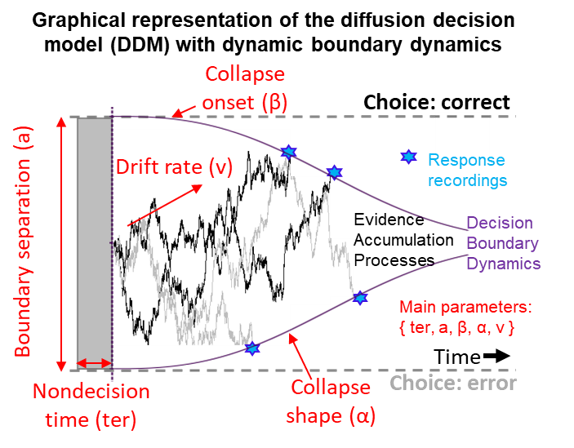

In [51]:
#![DDM_Angle](DDM_Angle.png)
#from IPython.display import Image
# Display the image
Image(filename='DDM_Angle.png')

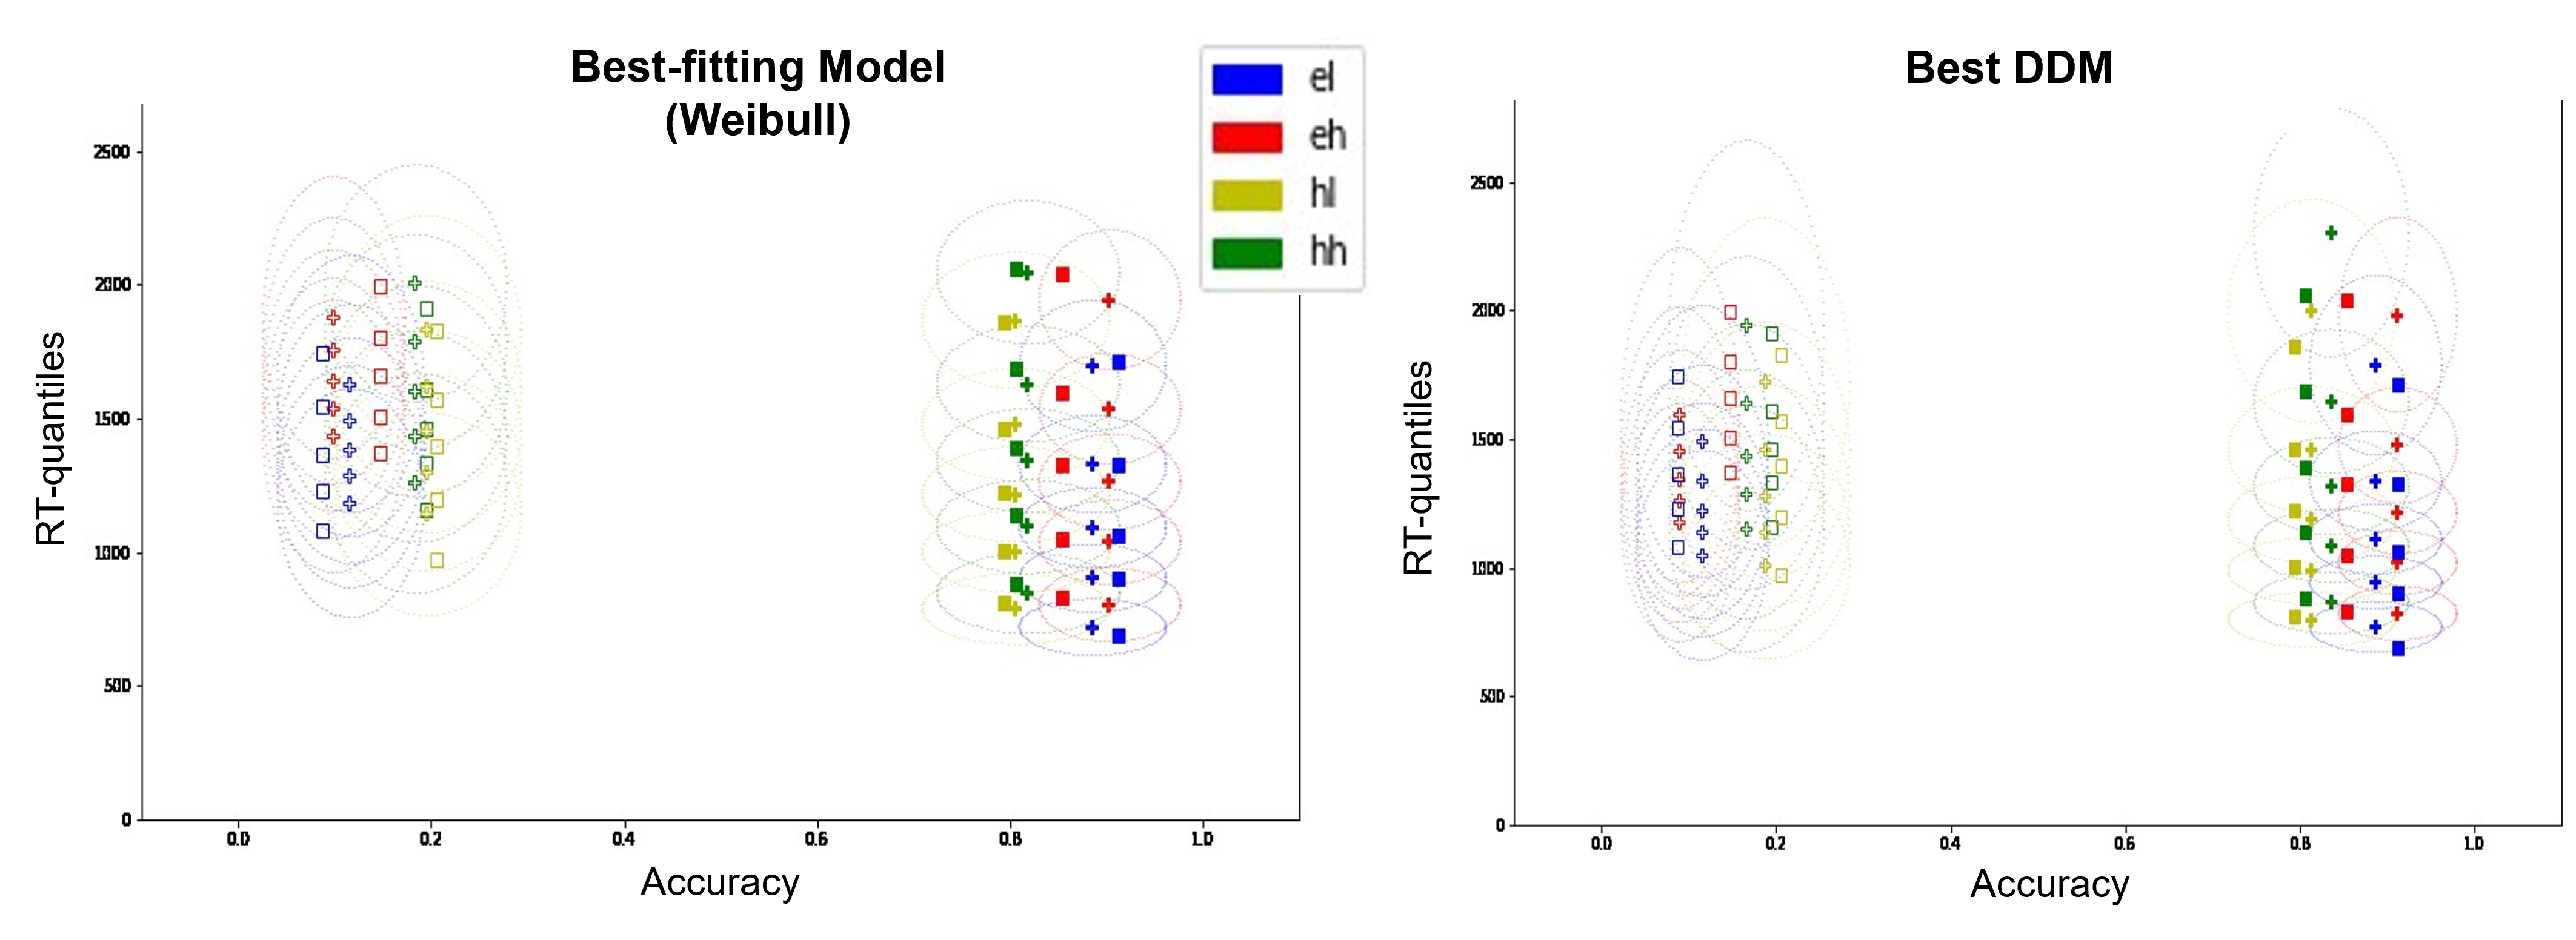

In [52]:
#![PPC_Example](PPC_Example.png)
#from IPython.display import Image
# Display the image
Image(filename='PPC_Example.png')

## code for this is available here: 
https://github.com/gingjehli/HDDM---Detailed-PPC